Description: Jupyter notebook to compare scalings of testing error wrt number of queries for different types of learners (passive learner and active learners HAL-FI/HAL-FIR) in the finite sample and asymptotic cases for fixed/adaptively growing query spaces

In [1]:
# Imports
import os, sys, types
import pathlib

In [2]:
# Add paths
import itertools
import math
import sympy
import numpy as np
import scipy.linalg
import scipy.stats
import scipy.optimize
import scipy.fftpack

import tensorflow  as  tf
tf.compat.v1.enable_eager_execution(config=None, device_policy=None, execution_mode=None)

#import seaborn as sns
#import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

import pickle

from importlib import reload
from sympy.physics.quantum.dagger import Dagger

In [3]:
# Local package imports
# Update this with setup & develop later
PROJECT_PATH = str(pathlib.Path().resolve().parent)
sys.path.append(PROJECT_PATH)

In [4]:
import hamiltonianlearner

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
import hamiltonianlearner.quantum_system_oracles.process_data as process_data
import hamiltonianlearner.quantum_system_oracles.simulate_nature as simulate_nature
import hamiltonianlearner.quantum_system_models.quantum_device_models as quantum_device_models
import hamiltonianlearner.learners.design_experiment as design_experiment

In [6]:
# estimators
import hamiltonianlearner.estimators.initial_estimators as initial_estimators
import hamiltonianlearner.estimators.mle_estimators as mle_estimators
import hamiltonianlearner.estimators.estimation_procedure as estimation_procedure

In [7]:
import hamiltonianlearner.learners.benchmark_design_experiment as benchmark_design_experiment
import hamiltonianlearner.utils.learner_experiment_utils as learner_experiment_utils
import hamiltonianlearner.utils.job_helper as job_helper
import hamiltonianlearner.utils.job_processor as job_processor

In [8]:
# For plotting purposes
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
import yaml
#import unit_tests

In [10]:
import functools

In [11]:
# Cool reloading
# Reference: https://stackoverflow.com/questions/28101895/reloading-packages-and-their-submodules-recursively-in-python

def reload_package(package):
    assert(hasattr(package, "__package__"))
    fn = package.__file__
    fn_dir = os.path.dirname(fn) + os.sep
    module_visit = {fn}
    del fn

    def reload_recursive_ex(module):
        reload(module)

        for module_child in vars(module).values():
            if isinstance(module_child, types.ModuleType):
                fn_child = getattr(module_child, "__file__", None)
                if (fn_child is not None) and fn_child.startswith(fn_dir):
                    if fn_child not in module_visit:
                        # print("reloading:", fn_child, "from", module)
                        module_visit.add(fn_child)
                        reload_recursive_ex(module_child)

    return reload_recursive_ex(package)

### Global parameters

In [12]:
def kron(a, b):
    return np.matrix(scipy.linalg.kron(a, b))

In [13]:
si = np.array([ [1, 0], [0, 1] ])
sx = np.array([ [0, 1], [1, 0] ])
sy = np.array([ [0, -1j], [1j, 0] ])
sz = np.array([ [1, 0], [0, -1] ])

# According to Ed's slides and answers verified -- match!
moset = {0: [si,scipy.linalg.expm(1j*(np.pi/4)*sy)], 1: [si,scipy.linalg.expm(-1j*(np.pi/4)*sx)], 2: [si,si]}
prepset = {0: [si, si], 1: [sx, si]}

In [14]:
# Time Stamps similar to data
time_stamps = np.linspace(1e-7,6e-7,81)

# Asymptotic Scalings -- fixed query space

## Quantum Device

In [15]:
# Define time-stamps under consideration
time_stamps = np.linspace(1e-7,6e-7,81)

xi_t = 1e-7
time_stamps_nd = time_stamps/xi_t

In [16]:
# Define the ActionSpace
xi_J = 1e6*np.ones(6)
xi_param = np.array([1e6,1,1,1e6,1,1])

A_cr = simulate_nature.Action_Space(moset, prepset, time_stamps_nd, xi_t, xi_J, xi_param=xi_param)

In [17]:
# Hamiltonian Description
J_num = np.array([-4591284.15156123, -1378867.53815859,  -416336.60548091,
                    6513769.17811964,  1377973.27790347,   528855.26396758])

# J_num = np.array([-4568258.88132824, -1465045.02848701,  -290468.97835928,
#                   6499545.9801579,  1390900.08768167,   413722.74870734])

# Noise Model
qs_T1 = 1e-6*np.array([94.0278, 75.71162])
qs_T2 = 1e-6*np.array([177.22575, 128.0758598])

decoherence_model = functools.partial(quantum_device_models.decoherence_single_qubit_model, t1=np.mean(qs_T1), t2=np.mean(qs_T2))
decoherence_model2 = functools.partial(quantum_device_models.decoherence_two_qubit_model, 
                                       t1_array=qs_T1, 
                                       t2_array=qs_T2)

qs_noise = {'readout': [0.0078125, 0.033203125], 
            'control_noise': functools.partial(quantum_device_models.data_driven_teff_noise_model, FLAG_ibmq_boel=True),
            'grad_control_noise': functools.partial(quantum_device_models.grad_data_driven_teff_noise_model, FLAG_ibmq_boel=True),
            'T1': qs_T1,
            'T2': qs_T2,
            'decoherence': decoherence_model2
           }

## Noiseless

In [18]:
reload_package(hamiltonianlearner)

In [19]:
# Define SystemModel
qs_model_noiseless = quantum_device_models.SystemModel(J_num, xi_J, 
                                                       FLAG_readout_noise=False, 
                                                       FLAG_control_noise=False)

In [20]:
# Define the number of queries over rounds
max_k = 51

# Array containing number of batches
n_batches = A_cr.N_actions*np.ones(max_k, dtype=int)
n_batches[0] = 5*A_cr.N_actions

In [21]:
# Get scalings for Passive Learner
policy_type = 'passive'
type_param = 'param'
query_space, _ = job_helper.setup_action_space(time_stamps, J_num)

HAL_FI_param = design_experiment.ActiveLearner(policy_type=policy_type,
                                               FLAG_normalization=True,
                                               FLAG_noise=True,
                                               FLAG_constraints=False,
                                               query_constraints=None,
                                               type_param=type_param)

res_PL_noiseless = design_experiment.optimal_scalings(qs_model_noiseless, query_space, xi_t, 
                                                      n_batches, max_k, HAL_FI_param)

Running with lower_limits on query constraints: False


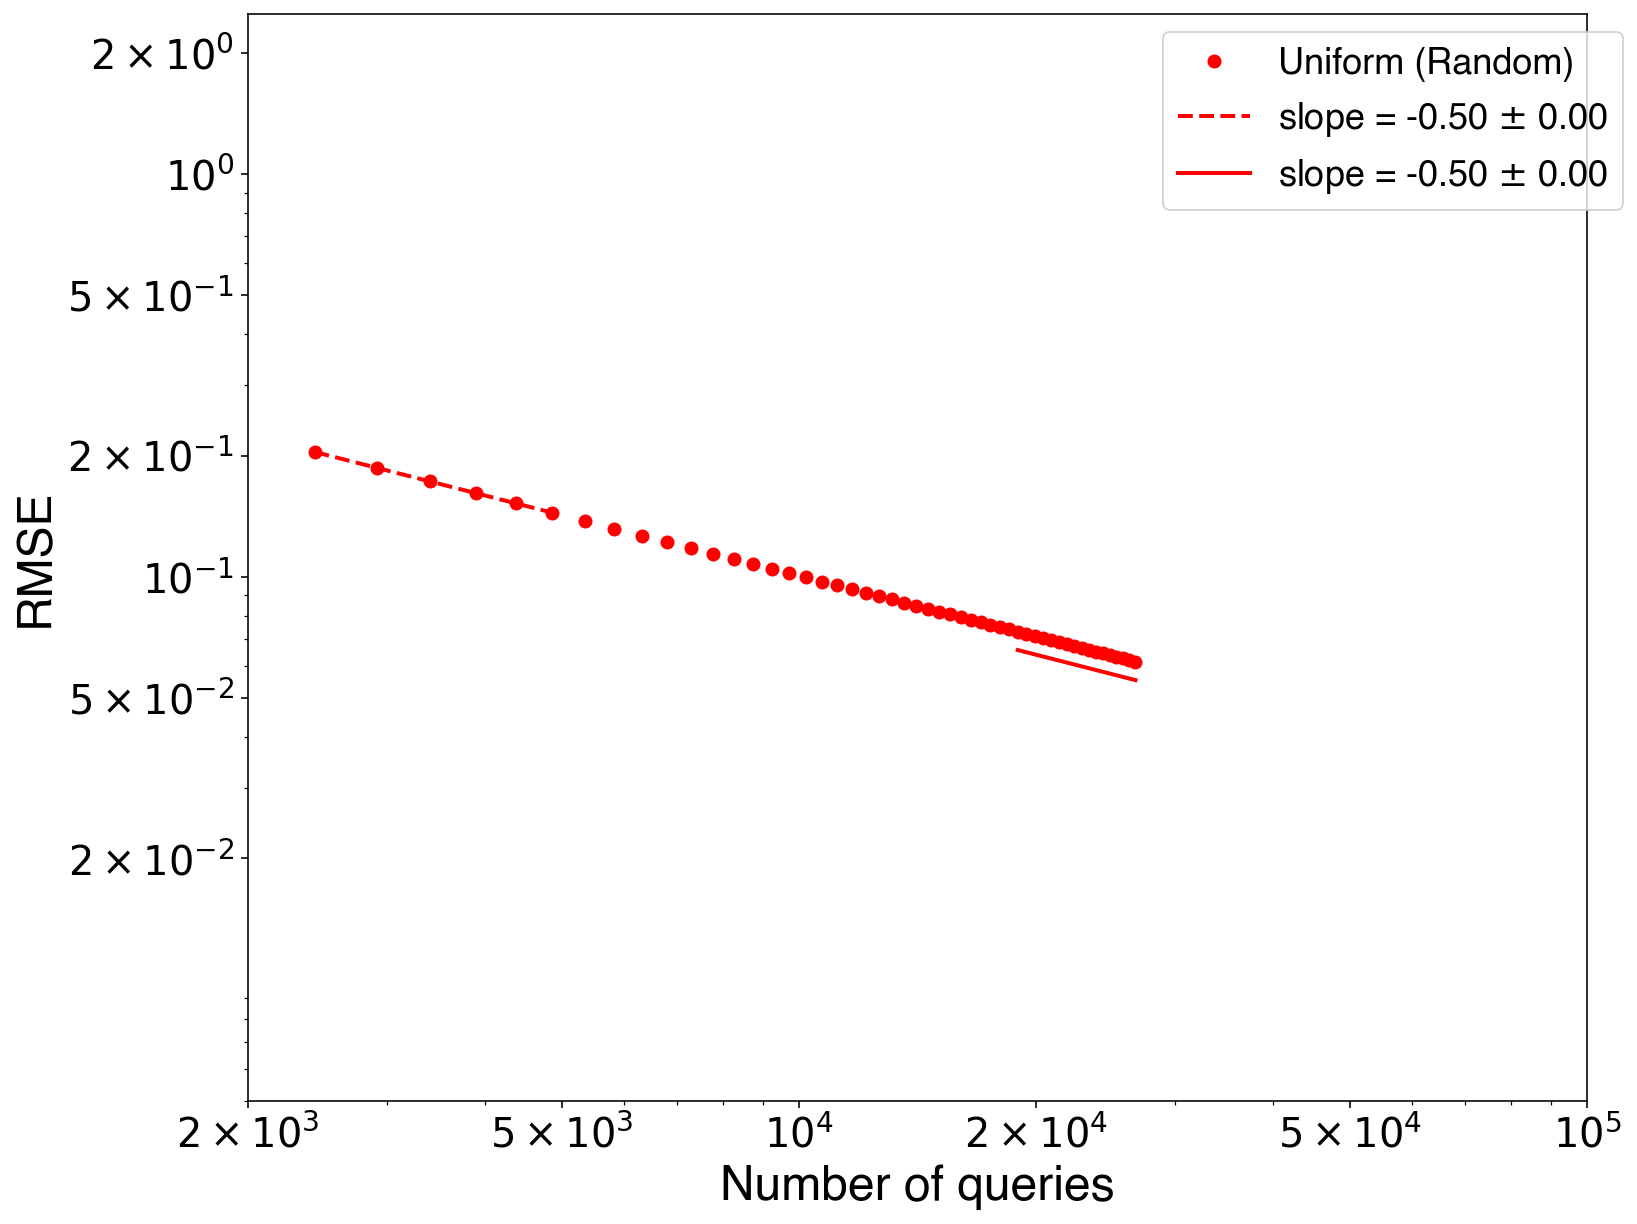

In [22]:
job_processor.plot_trend([res_PL_noiseless['rmse_param']], [res_PL_noiseless['N_p']])

In [61]:
# Get scalings for ActiveLearner
policy_type = 'FI'
type_param = 'param'
query_space, _ = job_helper.setup_action_space(time_stamps, J_num)

HAL_FI_param = design_experiment.ActiveLearner(policy_type=policy_type,
                                               FLAG_normalization=True,
                                               FLAG_noise=True,
                                               FLAG_constraints=False,
                                               query_constraints=None,
                                               type_param=type_param)

res_FI_noiseless = design_experiment.optimal_scalings(qs_model_noiseless, query_space, xi_t, 
                                                      n_batches, max_k, HAL_FI_param, FLAG_verbose=True)

Running with lower_limits on query constraints: False
k=10
k=20
k=30
k=40
k=50


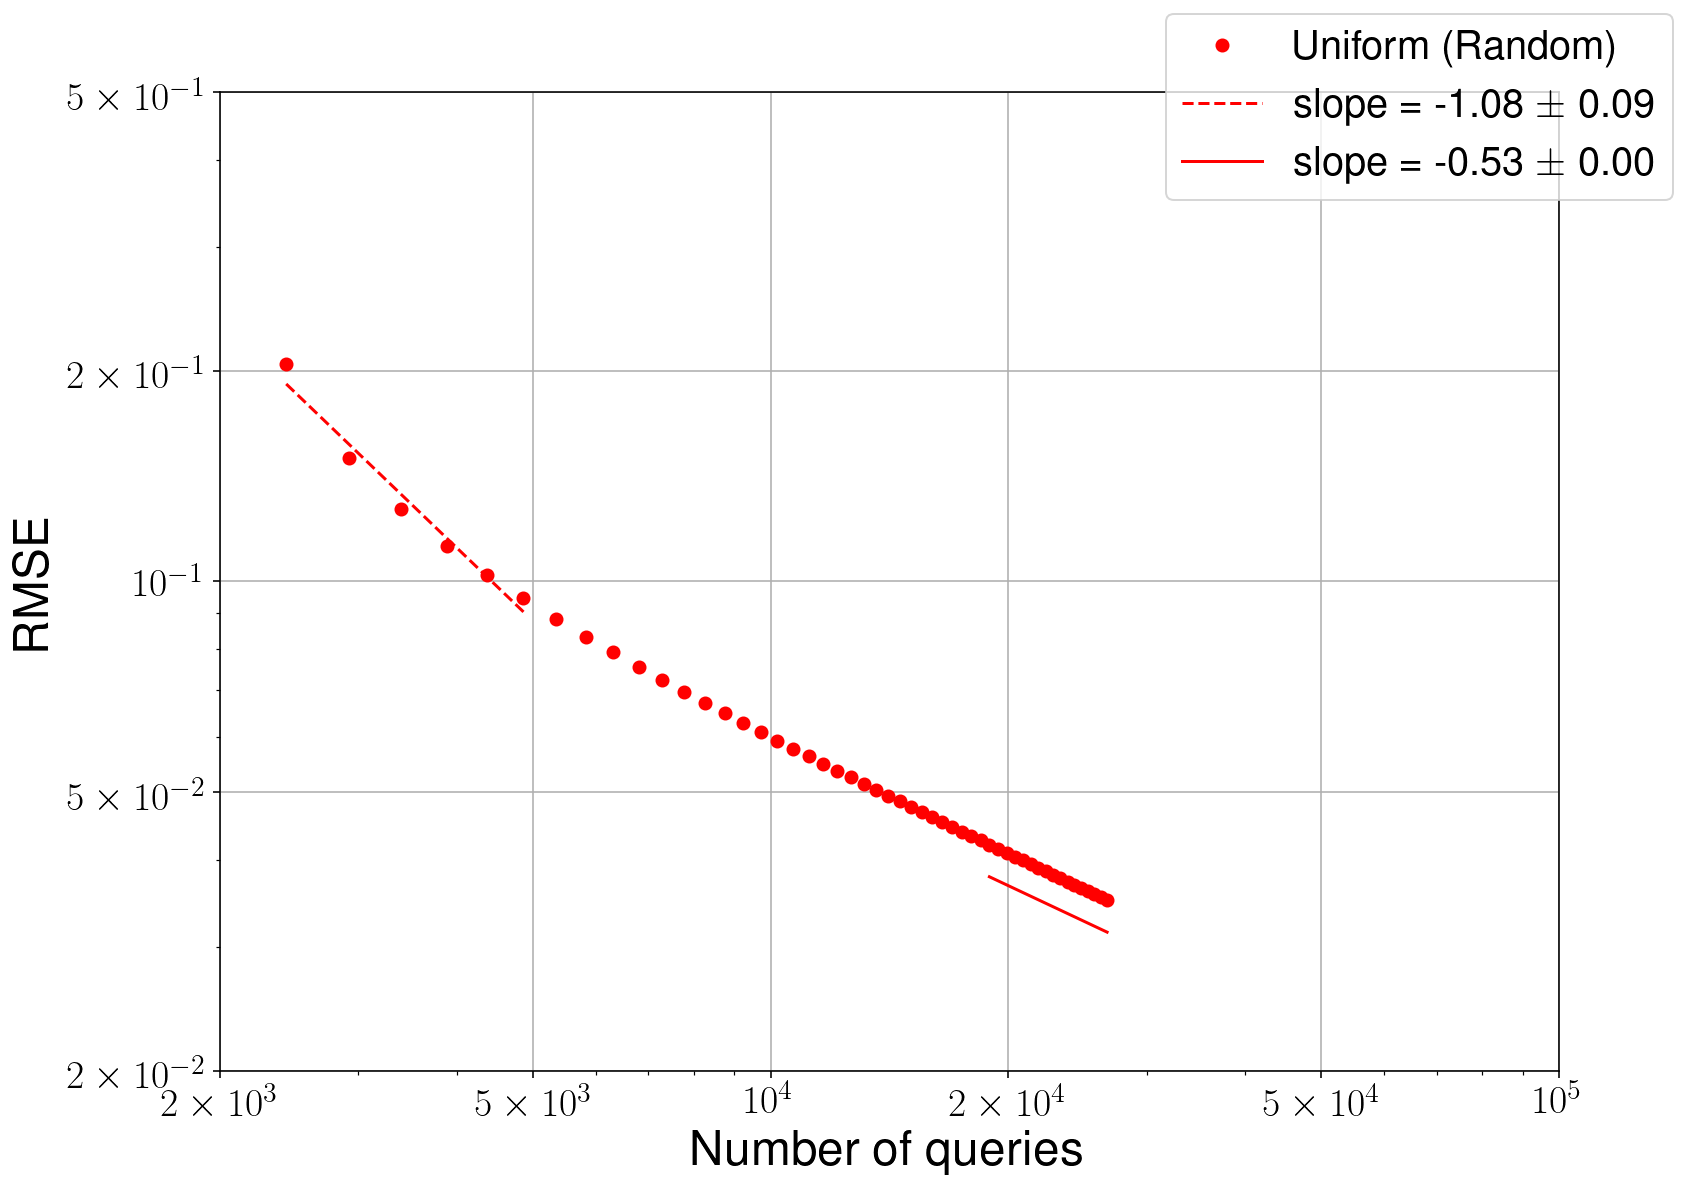

In [62]:
job_processor.plot_trend([res_FI_noiseless['rmse_param']], [res_FI_noiseless['N_p']])

## Noise

In [23]:
# Define SystemModel
qs_model_noisy = quantum_device_models.SystemModel(J_num, xi_J, noise=qs_noise, 
                                                   FLAG_readout_noise=True, 
                                                   FLAG_control_noise=True, 
                                                   FLAG_decoherence=True)

In [24]:
# Define the number of queries over rounds
max_k = 251

# Array containing number of batches
n_batches = A_cr.N_actions*np.ones(max_k, dtype=int)
n_batches[0] = 5*A_cr.N_actions

In [25]:
# Get scalings for Passive Learner
policy_type = 'passive'
type_param = 'J'
query_space, _ = job_helper.setup_action_space(time_stamps, J_num)

HAL_FI_param = design_experiment.ActiveLearner(policy_type=policy_type,
                                               FLAG_normalization=True,
                                               FLAG_noise=True,
                                               FLAG_constraints=False,
                                               query_constraints=None,
                                               type_param=type_param)

res_PL_noisy = design_experiment.optimal_scalings(qs_model_noisy, query_space, xi_t, 
                                                  n_batches, max_k, HAL_FI_param, FLAG_verbose=True)

Running with lower_limits on query constraints: False
k=50
k=100
k=150
k=200
k=250


In [26]:
# Get scalings for HAL-FI Active Learner
policy_type = 'FI'
type_param = 'J'
query_space, _ = job_helper.setup_action_space(time_stamps, J_num)

HAL_FI_param = design_experiment.ActiveLearner(policy_type=policy_type,
                                               FLAG_normalization=True,
                                               FLAG_noise=True,
                                               FLAG_constraints=False,
                                               query_constraints=None,
                                               type_param=type_param)

res_FI_noisy = design_experiment.optimal_scalings(qs_model_noisy, query_space, xi_t, 
                                                  n_batches, max_k, HAL_FI_param, FLAG_verbose=True)

Running with lower_limits on query constraints: False
k=50
k=100
k=150
k=200
k=250


In [27]:
# Get scalings for HAL-FIR Active Learner
policy_type = 'FIR'
type_param = 'J'
query_space, _ = job_helper.setup_action_space(time_stamps, J_num)

HAL_FIR_param = design_experiment.ActiveLearner(policy_type=policy_type,
                                               FLAG_normalization=True,
                                               FLAG_noise=True,
                                               FLAG_constraints=False,
                                               query_constraints=None,
                                               type_param=type_param)

res_FIR_noisy = design_experiment.optimal_scalings(qs_model_noisy, query_space, xi_t, 
                                                   n_batches, max_k, HAL_FIR_param, FLAG_verbose=True)

Running with lower_limits on query constraints: False
k=50
k=100
k=150
k=200
k=250


### RMSE

In [35]:
reload_package(hamiltonianlearner)

In [36]:
from hamiltonianlearner.utils import job_processor

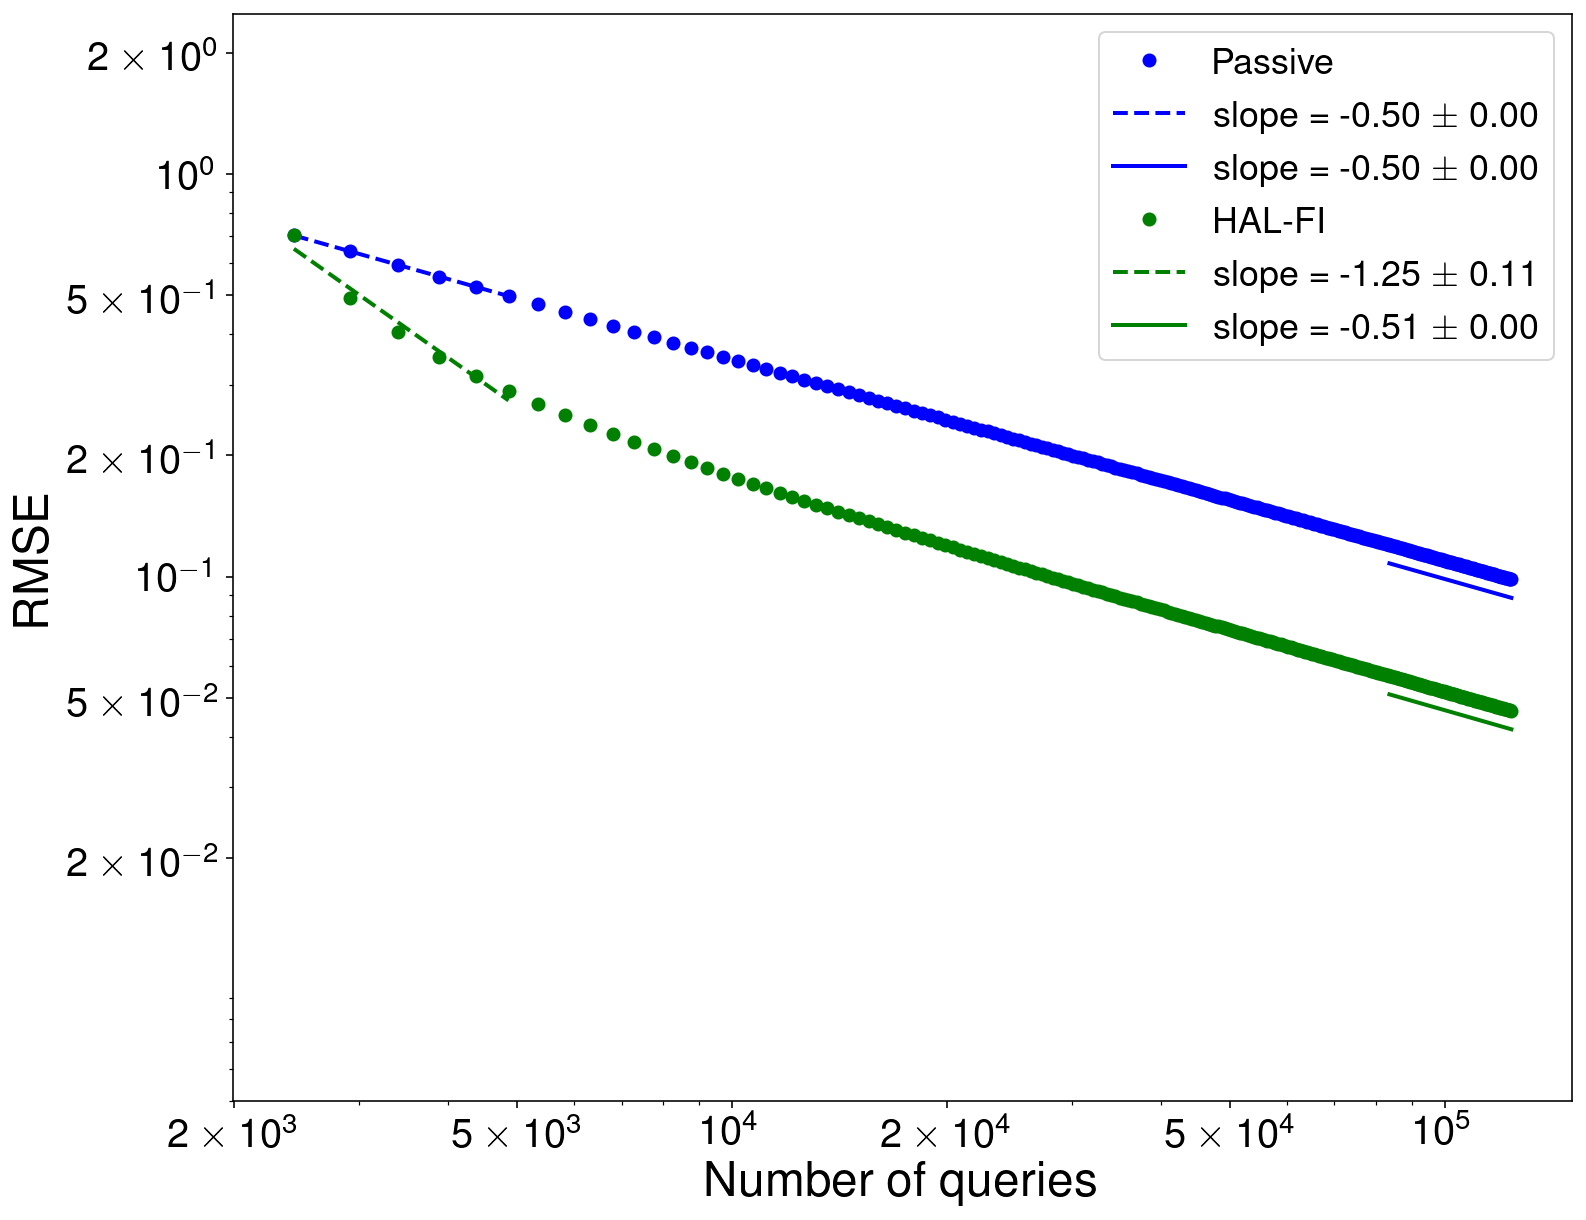

In [39]:
L2_error_plot = []
L2_error_plot.append(res_PL_noisy['rmse_param'])
L2_error_plot.append(res_FI_noisy['rmse_param'])
#L2_error_plot.append(res_FIR_noisy['rmse_param'])

nqueries_plot = []
nqueries_plot.append(res_PL_noisy['N_p'])
nqueries_plot.append(res_FI_noisy['N_p'])
#nqueries_plot.append(res_FIR_noisy['N_p'])

labels_plot = []
labels_plot.append('Passive')
labels_plot.append('HAL-FI')
#labels_plot.append('HAL-FIR')

# plotting options
plotting_options = {'label_learners': labels_plot, 
                    'skip_learner': 1,
                    'slope_scales': np.array([0.9,0.9,0.9,0.9]),
                    'FLAG_testing_error': False, 'FLAG_long_time_range': False,
                    'save_filename': "crb_rmse_noisy_sim.pdf",
                    'FLAG_legend_outside': False}

job_processor.plot_trend(L2_error_plot, nqueries_plot, plotting_options=plotting_options)

### Testing Error

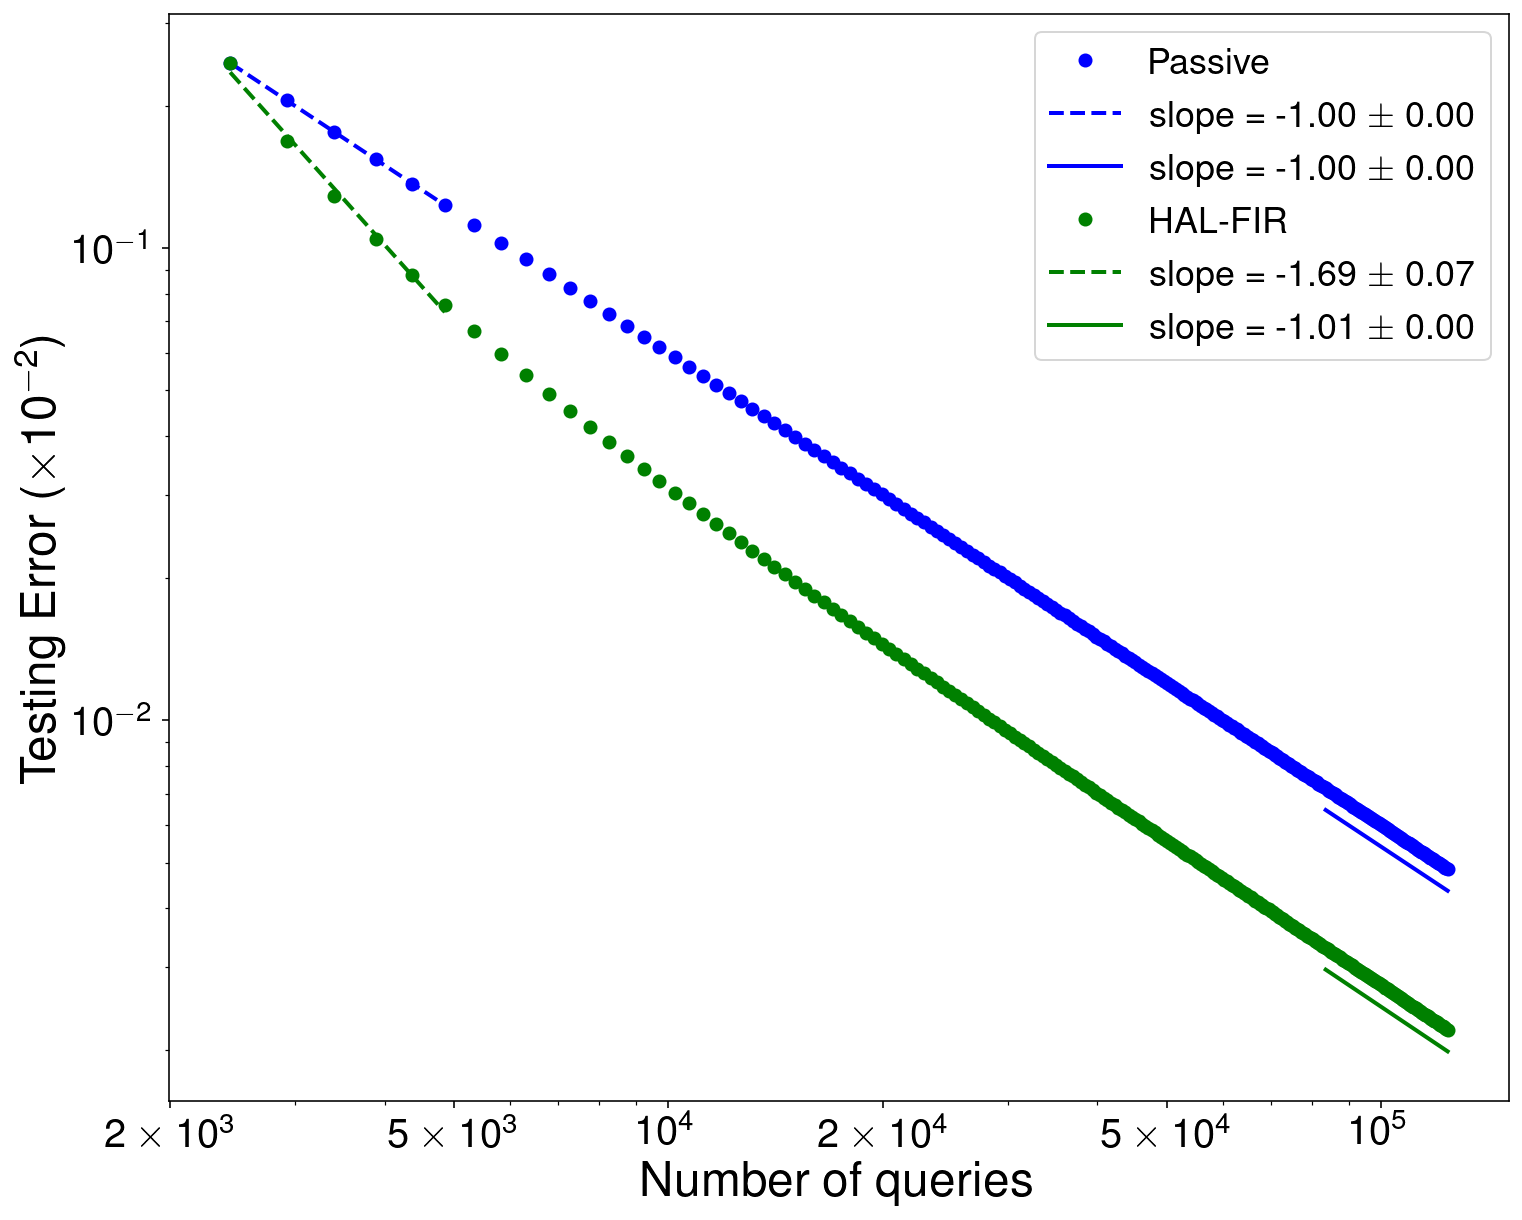

In [38]:
L2_error_plot = []
L2_error_plot.append(res_PL_noisy['testing_error'])
#L2_error_plot.append(res_FI_noisy['testing_error'])
L2_error_plot.append(res_FIR_noisy['testing_error'])

nqueries_plot = []
nqueries_plot.append(res_PL_noisy['N_p'])
#nqueries_plot.append(res_FI_noisy['N_p'])
nqueries_plot.append(res_FIR_noisy['N_p'])

labels_plot = []
labels_plot.append('Passive')
#labels_plot.append('HAL-FI')
labels_plot.append('HAL-FIR')

# plotting options
plotting_options = {'label_learners': labels_plot, 
                    'skip_learner': 1,
                    'slope_scales': np.array([0.9,0.9,0.9,0.9]),
                    'FLAG_testing_error': True, 'FLAG_long_time_range': False,
                    'save_filename': 'crb_testing_noisy_sim.pdf',
                    'FLAG_legend_outside': False}

job_processor.plot_trend(L2_error_plot, nqueries_plot, plotting_options=plotting_options)

# Asymptotic Scalings -- Reduced HL Problem

In [24]:
# Define query space
query_space = {'moset': moset, 'prepset': prepset, 'time_stamps': time_stamps}

## Noise -- Policy = Zero Rabi Crossing

In [284]:
reload_package(hamiltonianlearner)

In [285]:
# Define SystemModel
qs_model_noisy = quantum_device_models.SystemModel(J_num, xi_J, noise=qs_noise, 
                                                   FLAG_readout_noise=True, 
                                                   FLAG_control_noise=True, 
                                                   FLAG_decoherence=True)

In [286]:
# Conditions of run
max_k = 18

FLAG_normalization = True
FLAG_noise = True

# Array containing number of batches
n_batches = 2*486*np.ones(max_k, dtype=int)
n_batches[0] = 5*486

In [287]:
5*486 + 2*486*(max_k-1)

18954

In [288]:
# Zero Rabi Crossings (Fixed)
growth_time_stamps = None
type_spacing = 'linear'
type_param = 'param'
max_iter_growth = 1
config_array = [i for i in range(6)]

policy_type = ['uniform','uniform']
P_j = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

results_rabi_CR_uniform_d = benchmark_design_experiment.zero_rabi_policy_scalings(0, qs_model_noisy, 
                     query_space, xi_t, n_batches, max_k, policy_type=policy_type,
                     FLAG_normalization=FLAG_normalization, FLAG_noise=FLAG_noise,
                     max_iter_growth=max_iter_growth, config_array=config_array, P_j=P_j, type_param=type_param, 
                     freq_convert=None, growth_time_stamps=growth_time_stamps, type_spacing=type_spacing)

Running with lower_limits on query constraints: False


In [289]:
# Zero Rabi Crossings (Fixed)
growth_time_stamps = None
type_spacing = 'linear'
type_param = 'param'
max_iter_growth = 1
config_array = [i for i in range(6)]

policy_type = ['uniform','zero_rabi']
P_j = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

results_rabi_CR_fixed_d = benchmark_design_experiment.zero_rabi_policy_scalings(0, qs_model_noisy, 
                     query_space, xi_t, n_batches, max_k, policy_type=policy_type,
                     FLAG_normalization=FLAG_normalization, FLAG_noise=FLAG_noise,
                     max_iter_growth=max_iter_growth, config_array=config_array, P_j=P_j, type_param=type_param, 
                     freq_convert=None, growth_time_stamps=growth_time_stamps, type_spacing=type_spacing)

Running with lower_limits on query constraints: False


In [290]:
# Zero Rabi Crossings (Fixed)
growth_time_stamps = 'linear'
type_spacing = 'linear'
type_param = 'param'
max_iter_growth = 1
config_array = [i for i in range(6)]

policy_type = ['uniform','zero_rabi']
P_j = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

results_rabi_CR_lin_d = benchmark_design_experiment.zero_rabi_policy_scalings(0, qs_model_noisy, 
                     query_space, xi_t, n_batches, max_k, policy_type=policy_type,
                     FLAG_normalization=FLAG_normalization, FLAG_noise=FLAG_noise,
                     max_iter_growth=max_iter_growth, config_array=config_array, P_j=P_j, type_param=type_param, 
                     freq_convert=None, growth_time_stamps=growth_time_stamps, type_spacing=type_spacing)

Running with lower_limits on query constraints: False


In [291]:
# Zero Rabi Crossings (Fixed)
growth_time_stamps = 'exponential'
type_spacing = 'exponential'
type_param = 'param'
max_iter_growth = 1
config_array = [i for i in range(6)]

policy_type = ['uniform','zero_rabi']
P_j = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

results_rabi_CR_exp_d = benchmark_design_experiment.zero_rabi_policy_scalings(0, qs_model_noisy, 
                     query_space, xi_t, n_batches, max_k, policy_type=policy_type,
                     FLAG_normalization=FLAG_normalization, FLAG_noise=FLAG_noise,
                     max_iter_growth=max_iter_growth, config_array=config_array, P_j=P_j, type_param=type_param, 
                     freq_convert=None, growth_time_stamps=growth_time_stamps, type_spacing=type_spacing)

Running with lower_limits on query constraints: False


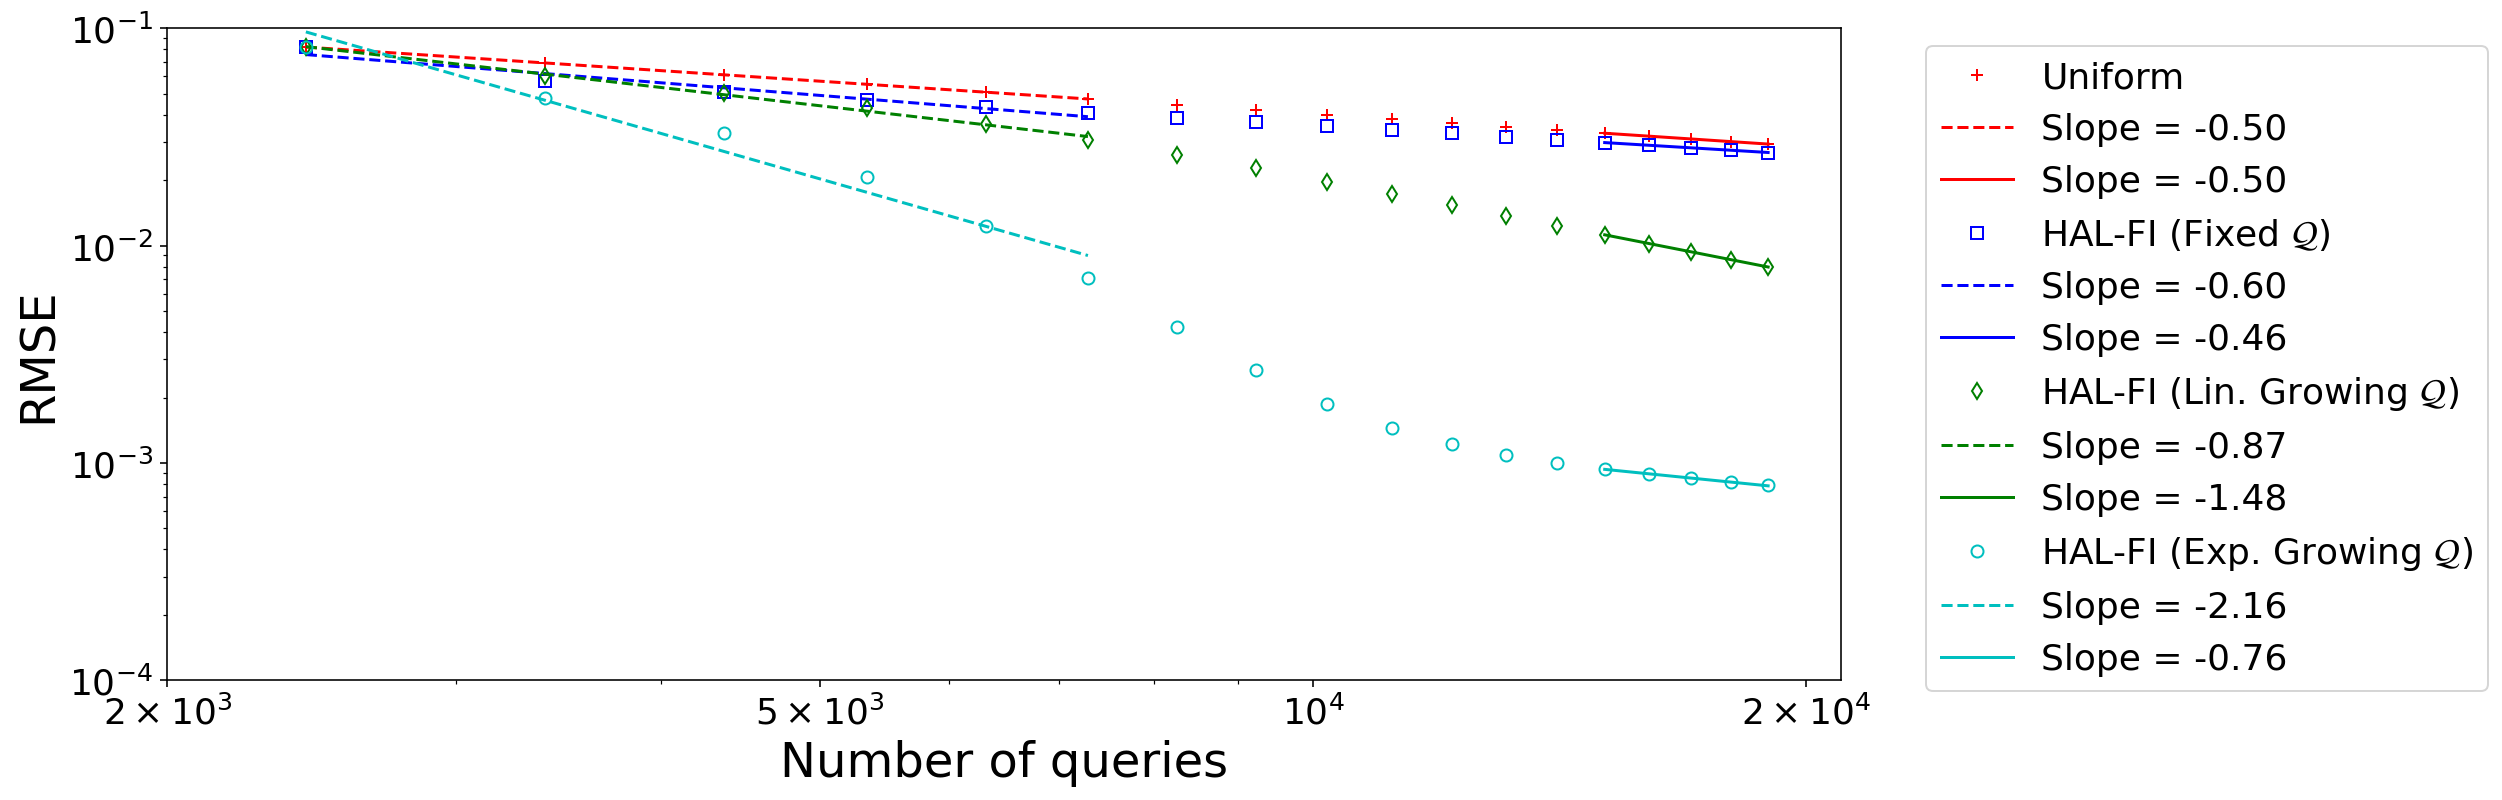

In [292]:
rmse_learners = []
rmse_learners.append(results_rabi_CR_uniform_d['rmse_param'])
rmse_learners.append(results_rabi_CR_fixed_d['rmse_param'])
rmse_learners.append(results_rabi_CR_lin_d['rmse_param'])
rmse_learners.append(results_rabi_CR_exp_d['rmse_param'])

_key = 'N_p'
nqueries_learners = []
nqueries_learners.append(results_rabi_CR_uniform_d[_key])
nqueries_learners.append(results_rabi_CR_fixed_d[_key])
nqueries_learners.append(results_rabi_CR_lin_d[_key])
nqueries_learners.append(results_rabi_CR_exp_d[_key])

labels_learners = ['Uniform', r'HAL-FI (Fixed $\mathcal{Q}$)', 
                   r'HAL-FI (Lin. Growing $\mathcal{Q}$)',
                   r'HAL-FI (Exp. Growing $\mathcal{Q}$)']

design_experiment.plot_trends_comparison_learners(rmse_learners, nqueries_learners,
                                                  labels_learners=labels_learners, 
                                                  save_filename='rmse_omega_decoherence_rabi_crossings.png',
                                                  figsize_plot=(15,6))

## Noise -- Policy = Zero Rabi Crossings and Max Amplitudes

In [295]:
# Define SystemModel
qs_model_noisy = quantum_device_models.SystemModel(J_num, xi_J, noise=qs_noise, 
                                                   FLAG_readout_noise=True, 
                                                   FLAG_control_noise=True, 
                                                   FLAG_decoherence=True)

In [296]:
# Conditions of run
max_k = 18

FLAG_normalization = True
FLAG_noise = True

# Array containing number of batches
n_batches = 2*486*np.ones(max_k, dtype=int)
n_batches[0] = 5*486

In [297]:
# Zero Rabi Crossings (Fixed)
growth_time_stamps = None
type_spacing = 'linear'
type_param = 'param'
max_iter_growth = 1
config_array = [i for i in range(6)]

policy_type = ['uniform','uniform']
P_j = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

results_rabi_max_CR_uniform_d = benchmark_design_experiment.zero_rabi_policy_scalings(0, qs_model_noisy, 
                     query_space, xi_t, n_batches, max_k, policy_type=policy_type,
                     FLAG_normalization=FLAG_normalization, FLAG_noise=FLAG_noise,
                     max_iter_growth=max_iter_growth, config_array=config_array, P_j=P_j, type_param=type_param, 
                     freq_convert=None, growth_time_stamps=growth_time_stamps, type_spacing=type_spacing)

Running with lower_limits on query constraints: False


In [298]:
# Zero Rabi Crossings (Fixed)
growth_time_stamps = None
type_spacing = 'linear'
type_param = 'param'
max_iter_growth = 1
config_array = [i for i in range(6)]

policy_type = ['uniform','zero_max_rabi']
P_j = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

results_rabi_max_CR_fixed_d = benchmark_design_experiment.zero_rabi_policy_scalings(0, qs_model_noisy, 
                     query_space, xi_t, n_batches, max_k, policy_type=policy_type,
                     FLAG_normalization=FLAG_normalization, FLAG_noise=FLAG_noise,
                     max_iter_growth=max_iter_growth, config_array=config_array, P_j=P_j, type_param=type_param, 
                     freq_convert=None, growth_time_stamps=growth_time_stamps, type_spacing=type_spacing)

Running with lower_limits on query constraints: False


In [299]:
# Zero Rabi Crossings (Fixed)
growth_time_stamps = 'linear'
type_spacing = 'linear'
type_param = 'param'
max_iter_growth = 1
config_array = [i for i in range(6)]

policy_type = ['uniform','zero_max_rabi']
P_j = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

results_rabi_max_CR_lin_d = benchmark_design_experiment.zero_rabi_policy_scalings(0, qs_model_noisy, 
                     query_space, xi_t, n_batches, max_k, policy_type=policy_type,
                     FLAG_normalization=FLAG_normalization, FLAG_noise=FLAG_noise,
                     max_iter_growth=max_iter_growth, config_array=config_array, P_j=P_j, type_param=type_param, 
                     freq_convert=None, growth_time_stamps=growth_time_stamps, type_spacing=type_spacing)

Running with lower_limits on query constraints: False


In [300]:
# Zero Rabi Crossings (Fixed)
growth_time_stamps = 'exponential'
type_spacing = 'exponential'
type_param = 'param'
max_iter_growth = 1
config_array = [i for i in range(6)]

policy_type = ['uniform','zero_max_rabi']
P_j = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

results_rabi_max_CR_exp_d = benchmark_design_experiment.zero_rabi_policy_scalings(0, qs_model_noisy, 
                     query_space, xi_t, n_batches, max_k, policy_type=policy_type,
                     FLAG_normalization=FLAG_normalization, FLAG_noise=FLAG_noise,
                     max_iter_growth=max_iter_growth, config_array=config_array, P_j=P_j, type_param=type_param, 
                     freq_convert=None, growth_time_stamps=growth_time_stamps, type_spacing=type_spacing)

Running with lower_limits on query constraints: False


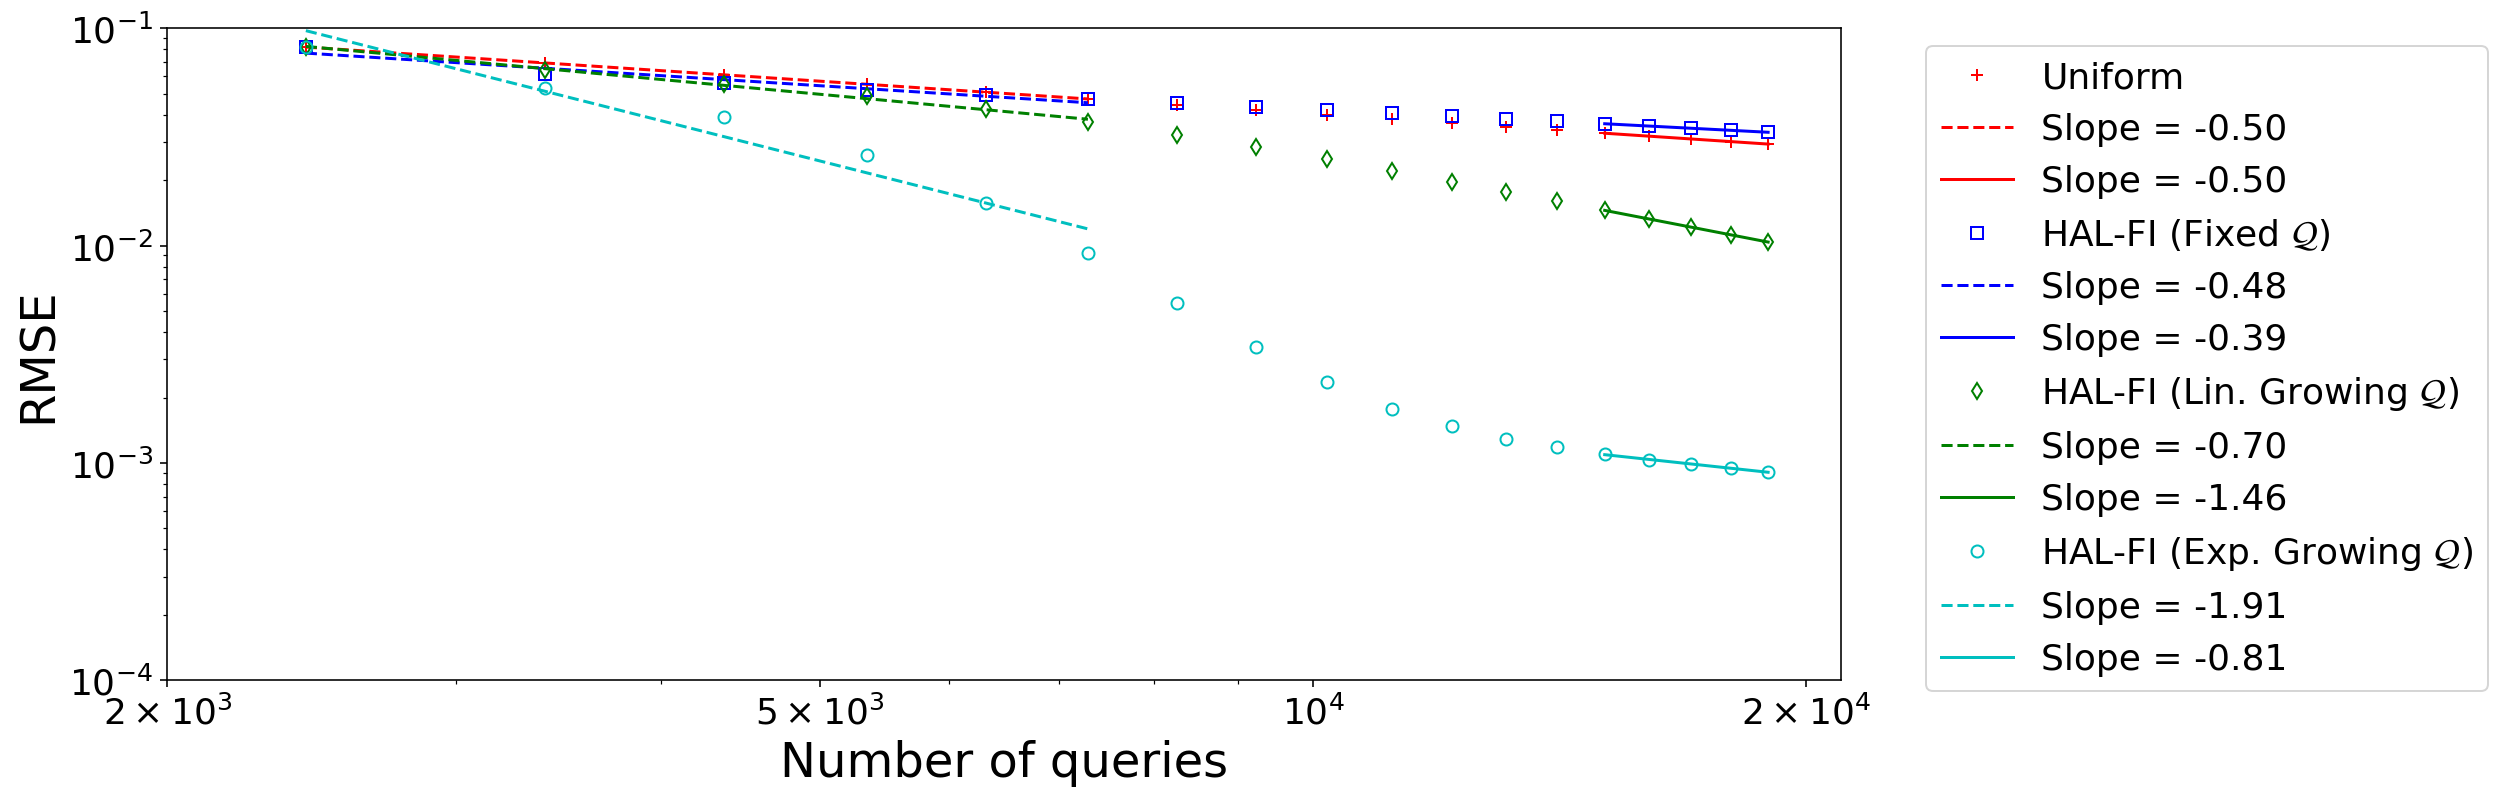

In [302]:
rmse_learners = []
rmse_learners.append(results_rabi_max_CR_uniform_d['rmse_param'])
rmse_learners.append(results_rabi_max_CR_fixed_d['rmse_param'])
rmse_learners.append(results_rabi_max_CR_lin_d['rmse_param'])
rmse_learners.append(results_rabi_max_CR_exp_d['rmse_param'])

_key = 'N_p'
nqueries_learners = []
nqueries_learners.append(results_rabi_max_CR_uniform_d[_key])
nqueries_learners.append(results_rabi_max_CR_fixed_d[_key])
nqueries_learners.append(results_rabi_max_CR_lin_d[_key])
nqueries_learners.append(results_rabi_max_CR_exp_d[_key])

labels_learners = ['Uniform', r'HAL-FI (Fixed $\mathcal{Q}$)', 
                   r'HAL-FI (Lin. Growing $\mathcal{Q}$)',
                   r'HAL-FI (Exp. Growing $\mathcal{Q}$)']

design_experiment.plot_trends_comparison_learners(rmse_learners, nqueries_learners,
                                                  labels_learners=labels_learners, 
                                                  save_filename='rmse_omega_decoherence_zero_max_rabi.png',
                                                  figsize_plot=(15,6))

In [303]:
rmse_learners_zero_max_rabi = np.copy(rmse_learners)

In [304]:
rmse_learners_zero_rabi

array([[0.08177304, 0.06911083, 0.06095002, 0.05513137, 0.05071349,
        0.04721169, 0.04434766, 0.04194868, 0.03990116, 0.03812688,
        0.03657001, 0.03518951, 0.03395441, 0.03284084, 0.03183011,
        0.0309073 , 0.03006037, 0.02927944],
       [0.08177304, 0.05695638, 0.05065873, 0.04653117, 0.04339138,
        0.04085646, 0.0387397 , 0.03693159, 0.03536097, 0.03397864,
        0.03274896, 0.0316453 , 0.03064724, 0.02973875, 0.02890708,
        0.02814189, 0.02743472, 0.02677855],
       [0.08177304, 0.06010945, 0.05042706, 0.04273651, 0.03615639,
        0.03067639, 0.02621313, 0.02260748, 0.01968822, 0.01730888,
        0.01535072, 0.01372348, 0.01235718, 0.01119937, 0.01020911,
        0.00935542, 0.00861363, 0.00796474],
       [0.08177304, 0.04794001, 0.03304395, 0.02072319, 0.01223837,
        0.0071113 , 0.00422814, 0.00267611, 0.00186636, 0.00144638,
        0.00122232, 0.00109102, 0.00100292, 0.00093847, 0.00088867,
        0.0008487 , 0.00081571, 0.00078789]])

In [306]:
rmse_learners_zero_max_rabi - rmse_learners_zero_rabi

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.00436151, 0.00497724, 0.00550482, 0.00589449,
        0.00616862, 0.00635572, 0.00647881, 0.00655494, 0.00659646,
        0.00661234, 0.00660912, 0.00659164, 0.0065635 , 0.00652739,
        0.00648537, 0.00643901, 0.00638949],
       [0.        , 0.00418013, 0.00496841, 0.00576802, 0.0062671 ,
        0.00632348, 0.00608399, 0.00566709, 0.00520053, 0.004748  ,
        0.00433054, 0.00394653, 0.00360306, 0.00330145, 0.0030366 ,
        0.00280026, 0.00259025, 0.00240468],
       [0.        , 0.00487449, 0.0061461 , 0.00522105, 0.00347427,
        0.0020933 , 0.00123817, 0.00075121, 0.0004814 , 0.00033293,
        0.00025015, 0.00020357, 0.0001764 , 0.00015857, 0.00014582,
        0.00013617, 0.00012856, 0.00012238]])

## Noise -- Policy = Max. Entropy (A=0.3)

In [354]:
reload_package(hamiltonianlearner)

In [355]:
# Define SystemModel
qs_model_noisy = quantum_device_models.SystemModel(J_num, xi_J, noise=qs_noise, 
                                                   FLAG_readout_noise=True, 
                                                   FLAG_control_noise=True, 
                                                   FLAG_decoherence=True)

In [356]:
# Conditions of run
max_k = 18

FLAG_normalization = True
FLAG_noise = True

# Array containing number of batches
n_batches = 2*486*np.ones(max_k, dtype=int)
n_batches[0] = 5*486

### Uniform

In [357]:
# Zero Rabi Crossings (Fixed)
growth_time_stamps = None
type_spacing = 'linear'
type_param = 'param'
max_iter_growth = 1
config_array = [i for i in range(6)]

policy_type = ['uniform','uniform']
P_j = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

results_entropy_CR_uniform_d = benchmark_design_experiment.zero_rabi_policy_scalings(0, qs_model_noisy, 
                     query_space, xi_t, n_batches, max_k, policy_type=policy_type,
                     FLAG_normalization=FLAG_normalization, FLAG_noise=FLAG_noise,
                     max_iter_growth=max_iter_growth, config_array=config_array, P_j=P_j, type_param=type_param, 
                     freq_convert=None, growth_time_stamps=growth_time_stamps, type_spacing=type_spacing)

Running with lower_limits on query constraints: False


### Fixed qs

In [358]:
# Zero Rabi Crossings (Fixed)
growth_time_stamps = None
type_spacing = 'linear'
type_param = 'param'
max_iter_growth = 1
config_array = [i for i in range(6)]

policy_type = ['uniform','max_entropy']
P_j = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

results_entropy_CR_fixed_d = benchmark_design_experiment.zero_rabi_policy_scalings(0, qs_model_noisy, 
                     query_space, xi_t, n_batches, max_k, policy_type=policy_type,
                     FLAG_normalization=FLAG_normalization, FLAG_noise=FLAG_noise,
                     max_iter_growth=max_iter_growth, config_array=config_array, P_j=P_j, type_param=type_param, 
                     freq_convert=None, growth_time_stamps=growth_time_stamps, type_spacing=type_spacing)

Running with lower_limits on query constraints: False


TypeError: can't multiply sequence by non-int of type 'float'

### Lin. growing qs

In [325]:
# Zero Rabi Crossings (Fixed)
growth_time_stamps = 'linear'
type_spacing = 'linear'
type_param = 'param'
max_iter_growth = 1
config_array = [i for i in range(6)]

policy_type = ['uniform','max_entropy']
P_j = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

results_entropy_CR_lin_d = benchmark_design_experiment.zero_rabi_policy_scalings(0, qs_model_noisy, 
                     query_space, xi_t, n_batches, max_k, policy_type=policy_type,
                     FLAG_normalization=FLAG_normalization, FLAG_noise=FLAG_noise,
                     max_iter_growth=max_iter_growth, config_array=config_array, P_j=P_j, type_param=type_param, 
                     freq_convert=None, growth_time_stamps=growth_time_stamps, type_spacing=type_spacing,
                                                                             FLAG_verbose=True)

Running with lower_limits on query constraints: False
Policy being used is uniform
Using linear growing query space with linear spaced time stamps
Updating query space!
2
[0, 1, 2]
[[1.06023488 0.        ]
 [0.         0.70650422]]
[[1321.4976984     0.        ]
 [   0.          994.43276788]]
Updating query space!
3
[0, 1, 2, 3]
[[2.61038081 0.        ]
 [0.         2.24055335]]
[[3858.78784557    0.        ]
 [   0.         3172.25062675]]
Updating query space!
4
[0, 1, 2, 3, 4]
[[6.63194814 0.        ]
 [0.         1.86982152]]
[[10305.04143712     0.        ]
 [    0.          4989.71714458]]
Updating query space!
5
[0, 1, 2, 3, 4, 5]
[[10.0445315   0.        ]
 [ 0.          4.75215935]]
[[20068.32605146     0.        ]
 [    0.          9608.81603731]]
Updating query space!
6
[0, 1, 2, 3, 4, 5, 6]
[[13.63565788  0.        ]
 [ 0.          5.36737295]]
[[33322.18550788     0.        ]
 [    0.         14825.90254133]]
k=5
Updating query space!
7
[0, 1, 2, 3, 4, 5, 6, 7]
[[16.25869

### Exp. growing qs

In [360]:
# Zero Rabi Crossings (Fixed)
growth_time_stamps = 'exponential'
type_spacing = 'exponential'
type_param = 'param'
max_iter_growth = 1
config_array = [i for i in range(6)]
FLAG_growing_sampling_time = True

policy_type = ['uniform','max_entropy']
P_j = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

results_entropy_CR_exp_d = benchmark_design_experiment.zero_rabi_policy_scalings(0, qs_model_noisy, 
                     query_space, xi_t, n_batches, max_k, policy_type=policy_type,
                     FLAG_normalization=FLAG_normalization, FLAG_noise=FLAG_noise,
                     max_iter_growth=max_iter_growth, config_array=config_array, P_j=P_j, type_param=type_param, 
                     freq_convert=None, growth_time_stamps=growth_time_stamps, type_spacing=type_spacing,
                                                                             FLAG_verbose=True,
                                                                                 FLAG_growing_sampling_time=True)

Running with lower_limits on query constraints: False
Policy being used is uniform
Using exponential growing query space with exponential spaced time stamps
Updating query space!
2
[1, 2, 4]
[[1.06023488 0.        ]
 [0.         0.70650422]]
[[1321.4976984     0.        ]
 [   0.          994.43276788]]
Updating query space!
3
[1, 2, 4, 8]
[[5.68547311 0.        ]
 [0.         3.01094808]]
[[6847.77756355    0.        ]
 [   0.         3921.07430185]]
Updating query space!
4
[1, 2, 4, 8, 16]
[[14.36662953  0.        ]
 [ 0.         15.20619497]]
[[20812.14146513     0.        ]
 [    0.         18701.49580792]]
Updating query space!
5
[1, 2, 4, 8, 16, 32]
[[52.40150677  0.        ]
 [ 0.         42.55164696]]
[[71746.40604767     0.        ]
 [    0.         60061.6966547 ]]
Updating query space!
6
[1, 2, 4, 8, 16, 32, 64]
[[207.74918679   0.        ]
 [  0.         160.68544471]]
[[273678.61560753      0.        ]
 [     0.         216247.94891478]]
k=5
Updating query space!
7
[1, 2, 

### Summary

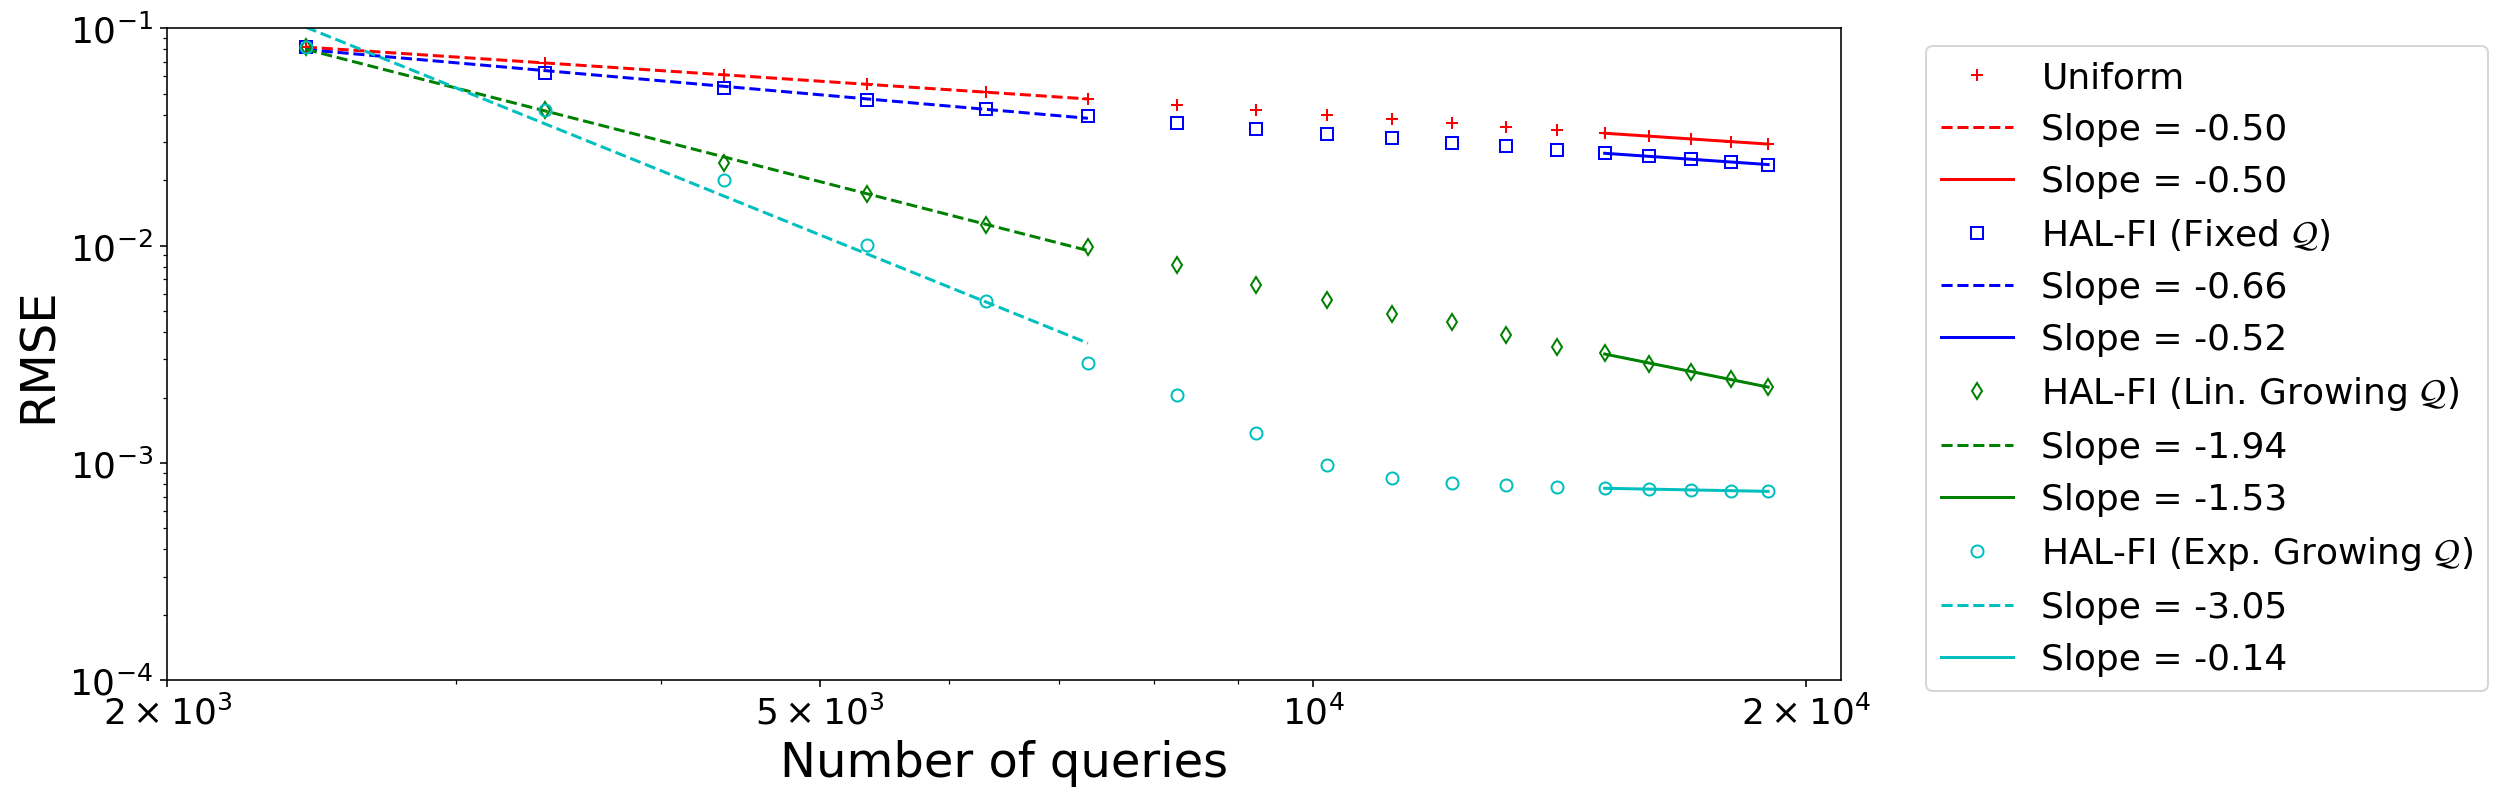

In [361]:
rmse_learners = []
rmse_learners.append(results_entropy_CR_uniform_d['rmse_param'])
rmse_learners.append(results_entropy_CR_fixed_d['rmse_param'])
rmse_learners.append(results_entropy_CR_lin_d['rmse_param'])
rmse_learners.append(results_entropy_CR_exp_d['rmse_param'])
# rmse_learners.append(results_rabi_CR_lin_d['rmse_param'])
# rmse_learners.append(results_rabi_CR_exp_d['rmse_param'])

_key = 'N_p'
nqueries_learners = []
nqueries_learners.append(results_entropy_CR_uniform_d[_key])
nqueries_learners.append(results_entropy_CR_fixed_d[_key])
nqueries_learners.append(results_entropy_CR_lin_d[_key])
nqueries_learners.append(results_entropy_CR_exp_d[_key])
# nqueries_learners.append(results_rabi_CR_lin_d[_key])
# nqueries_learners.append(results_rabi_CR_exp_d[_key])

labels_learners = ['Uniform', r'HAL-FI (Fixed $\mathcal{Q}$)', 
                   r'HAL-FI (Lin. Growing $\mathcal{Q}$)',
                   r'HAL-FI (Exp. Growing $\mathcal{Q}$)']

design_experiment.plot_trends_comparison_learners(rmse_learners, nqueries_learners,
                                                  labels_learners=labels_learners, 
                                                  save_filename='rmse_omega_decoherence_uncertainty_filtering.png',
                                                  figsize_plot=(15,6))

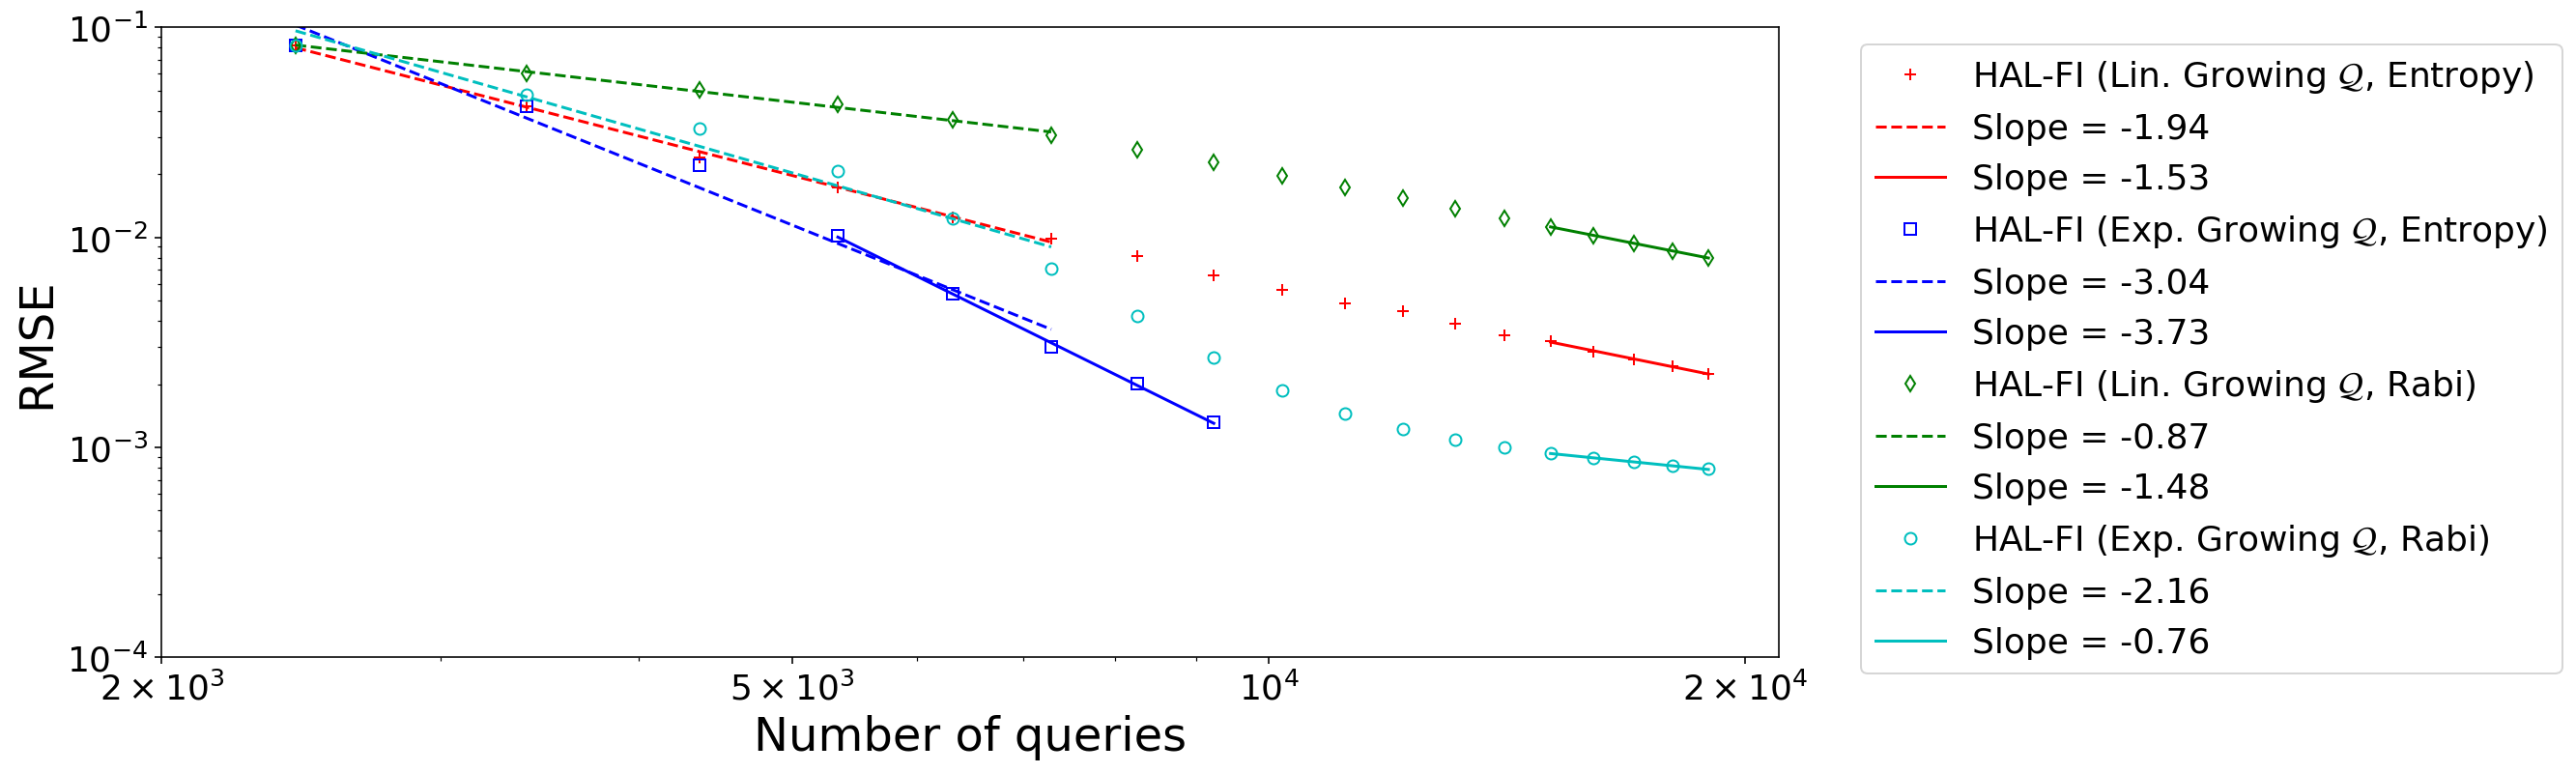

In [336]:
rmse_learners = []
rmse_learners.append(results_entropy_CR_lin_d['rmse_param'])
rmse_learners.append(results_entropy_CR_exp_d['rmse_param'])
rmse_learners.append(results_rabi_CR_lin_d['rmse_param'])
rmse_learners.append(results_rabi_CR_exp_d['rmse_param'])

_key = 'N_p'
nqueries_learners = []
nqueries_learners.append(results_entropy_CR_lin_d[_key])
nqueries_learners.append(results_entropy_CR_exp_d[_key])
nqueries_learners.append(results_rabi_CR_lin_d[_key])
nqueries_learners.append(results_rabi_CR_exp_d[_key])

labels_learners = [r'HAL-FI (Lin. Growing $\mathcal{Q}$, Entropy)',
                   r'HAL-FI (Exp. Growing $\mathcal{Q}$, Entropy)', 
                   r'HAL-FI (Lin. Growing $\mathcal{Q}$, Rabi)',
                   r'HAL-FI (Exp. Growing $\mathcal{Q}$, Rabi)']

design_experiment.plot_trends_comparison_learners(rmse_learners, nqueries_learners,
                                                  labels_learners=labels_learners, 
                                                  save_filename='rmse_omega_decoherence_quick_comparison.png',
                                                  figsize_plot=(15,6))

In [330]:
rmse_learners_entropy = np.copy(rmse_learners)

In [331]:
rmse_learners_entropy

array([array([0.08177304, 0.06911083, 0.06095002, 0.05513137, 0.05071349,
       0.04721169, 0.04434766, 0.04194868, 0.03990116, 0.03812688,
       0.03657001, 0.03518951, 0.03395441, 0.03284084, 0.03183011,
       0.0309073 , 0.03006037, 0.02927944]),
       array([0.08177304, 0.06231966, 0.05285699, 0.04682414, 0.04251331,
       0.03922456, 0.03660475, 0.03445225, 0.03264198, 0.03109142,
       0.02974363, 0.02855778, 0.02750374, 0.0265587 , 0.02570505,
       0.02492892, 0.02421921, 0.02356696]),
       array([0.08177304, 0.04197994, 0.02396628, 0.0172468 , 0.01240568,
       0.00987216, 0.00813769, 0.00660212, 0.00561034, 0.00483381,
       0.00444825, 0.00386151, 0.00341474, 0.00318877, 0.00286503,
       0.00261186, 0.0024433 , 0.00223035]),
       array([0.08177304, 0.04197994, 0.02200839, 0.01015606, 0.00539793,
       0.00299364, 0.00200331, 0.00131827])], dtype=object)

In [332]:
rmse_learners_zero_rabi

array([[0.08177304, 0.06911083, 0.06095002, 0.05513137, 0.05071349,
        0.04721169, 0.04434766, 0.04194868, 0.03990116, 0.03812688,
        0.03657001, 0.03518951, 0.03395441, 0.03284084, 0.03183011,
        0.0309073 , 0.03006037, 0.02927944],
       [0.08177304, 0.05695638, 0.05065873, 0.04653117, 0.04339138,
        0.04085646, 0.0387397 , 0.03693159, 0.03536097, 0.03397864,
        0.03274896, 0.0316453 , 0.03064724, 0.02973875, 0.02890708,
        0.02814189, 0.02743472, 0.02677855],
       [0.08177304, 0.06010945, 0.05042706, 0.04273651, 0.03615639,
        0.03067639, 0.02621313, 0.02260748, 0.01968822, 0.01730888,
        0.01535072, 0.01372348, 0.01235718, 0.01119937, 0.01020911,
        0.00935542, 0.00861363, 0.00796474],
       [0.08177304, 0.04794001, 0.03304395, 0.02072319, 0.01223837,
        0.0071113 , 0.00422814, 0.00267611, 0.00186636, 0.00144638,
        0.00122232, 0.00109102, 0.00100292, 0.00093847, 0.00088867,
        0.0008487 , 0.00081571, 0.00078789]])

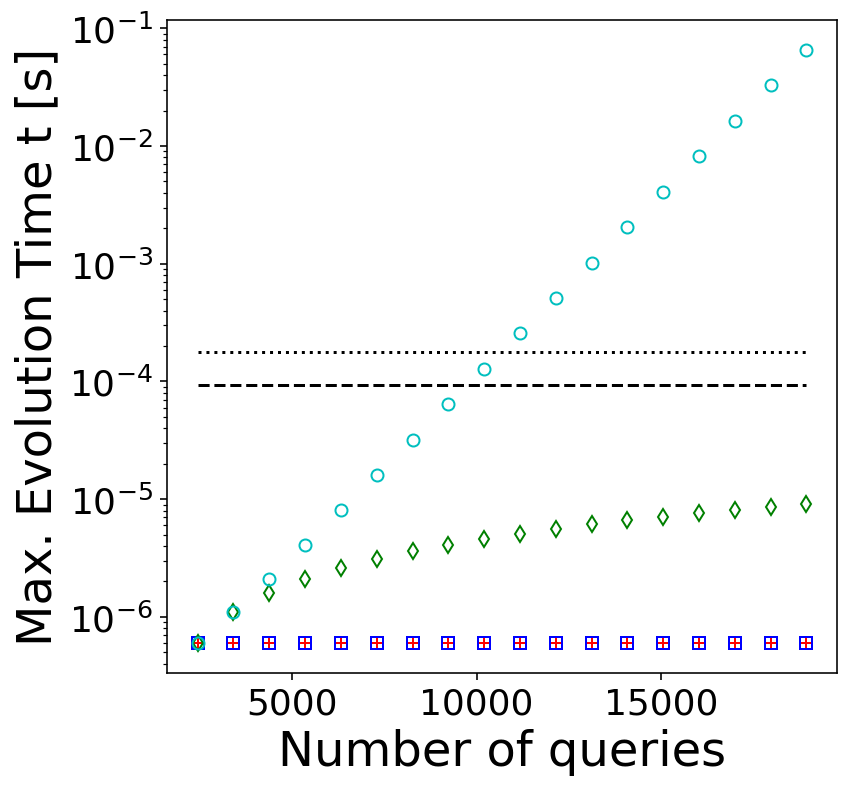

In [347]:
N_p_vec = results_rabi_CR_fixed_d['N_p']
N_p_min = N_p_vec[0]
N_p_max = N_p_vec[-1]

_key = 'tvec'
rmse_learners = []
rmse_learners.append(results_entropy_CR_uniform_d[_key])
rmse_learners.append(results_entropy_CR_fixed_d[_key])
#rmse_learners.append(results_rabi_CR_uniform_d[_key])
rmse_learners.append(results_entropy_CR_lin_d[_key])
rmse_learners.append(results_entropy_CR_exp_d[_key])

_key = 'N_p'
nqueries_learners = []
nqueries_learners.append(results_entropy_CR_uniform_d[_key])
nqueries_learners.append(results_entropy_CR_fixed_d[_key])
nqueries_learners.append(results_entropy_CR_lin_d[_key])
nqueries_learners.append(results_entropy_CR_exp_d[_key])

# labels_learners = ['Fixed Spaced Rabi', 
#                    'Lin. Spaced Rabi (1 iters)',
#                    'Exp. Spaced Rabi (1 iters)']

labels_learners = ['Passive Learner', r'HAL-FI (Fixed $\mathcal{Q}$)', 
                   r'HAL-FI (Lin. Growing $\mathcal{Q}$)',
                   r'HAL-FI (Exp. Growing $\mathcal{Q}$)']

design_experiment.plot_tvec_comparison_learners(rmse_learners, nqueries_learners, qs_T1, qs_T2, N_p_min, N_p_max,
                                                labels_learners=labels_learners, figsize_plot=(6,6),
                                                FLAG_legend=False)

In [337]:
_key = 'tvec'
results_rabi_max_CR_lin_d[_key]

[6e-07,
 1.6450038842250446e-06,
 2.460673526337414e-06,
 3.2763431684497836e-06,
 4.092012810562153e-06,
 4.907682452674523e-06,
 5.723352094786892e-06,
 6.539021736899262e-06,
 7.354691379011632e-06,
 8.170361021124001e-06,
 8.98603066323637e-06,
 9.801700305348742e-06,
 1.061736994746111e-05,
 1.1433039589573479e-05,
 1.224870923168585e-05,
 1.306437887379822e-05,
 1.3880048515910593e-05,
 1.4695718158022961e-05]

## Noise -- Policy = Max. Entropy (A=0.36)

In [18]:
reload_package(hamiltonianlearner)

In [19]:
# Define query space
query_space = {'moset': moset, 'prepset': prepset, 'time_stamps': time_stamps}

In [20]:
# Hamiltonian Description
J_num = np.array([-5104768.29368907, -1714597.08626246,  -307937.01997161,
                  7567993.21295566,  1776011.69540752,   415295.23318784])

# Noise Model
qs_T1 = 1e-6*np.array([94.0278, 75.71162])
qs_T2 = 1e-6*np.array([177.22575, 128.0758598])

decoherence_model = functools.partial(quantum_device_models.decoherence_single_qubit_model, t1=np.mean(qs_T1), t2=np.mean(qs_T2))
decoherence_model2 = functools.partial(quantum_device_models.decoherence_two_qubit_model, 
                                       t1_array=qs_T1, 
                                       t2_array=qs_T2)

qs_noise = {'readout': [0.0078125, 0.033203125], 
            'control_noise': functools.partial(quantum_device_models.data_driven_teff_noise_model, FLAG_ibmq_boel=True),
            'grad_control_noise': functools.partial(quantum_device_models.grad_data_driven_teff_noise_model, FLAG_ibmq_boel=True),
            'T1': qs_T1,
            'T2': qs_T2,
            'decoherence': decoherence_model2}

In [21]:
# Define SystemModel
qs_model_noisy = quantum_device_models.SystemModel(J_num, xi_J, noise=qs_noise, 
                                                   FLAG_readout_noise=True, 
                                                   FLAG_control_noise=True, 
                                                   FLAG_decoherence=True)

In [22]:
# Conditions of run
max_k = 19

FLAG_normalization = True
FLAG_noise = True

# Array containing number of batches
n_batches = 2*486*np.ones(max_k, dtype=int)
n_batches[0] = 5*486

### Uniform

In [81]:
growth_time_stamps = None
type_spacing = 'linear'
type_param = 'param'
max_iter_growth = 1
config_array = [i for i in range(6)]

policy_type = ['uniform','uniform']
P_j = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

results_entropy_CR_uniform_d = benchmark_design_experiment.zero_rabi_policy_scalings(0, qs_model_noisy, 
                     query_space, xi_t, n_batches, max_k, policy_type=policy_type,
                     FLAG_normalization=FLAG_normalization, FLAG_noise=FLAG_noise,
                     max_iter_growth=max_iter_growth, config_array=config_array, P_j=P_j, type_param=type_param, 
                     freq_convert=None, growth_time_stamps=growth_time_stamps, type_spacing=type_spacing)

Running with lower_limits on query constraints: False


### Fixed qs

In [82]:
growth_time_stamps = None
type_spacing = 'linear'
type_param = 'param'
max_iter_growth = 1
config_array = [i for i in range(6)]

policy_type = ['uniform','max_entropy']
P_j = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

results_entropy_CR_fixed_d = benchmark_design_experiment.zero_rabi_policy_scalings(0, qs_model_noisy, 
                     query_space, xi_t, n_batches, max_k, policy_type=policy_type,
                     FLAG_normalization=FLAG_normalization, FLAG_noise=FLAG_noise,
                     max_iter_growth=max_iter_growth, config_array=config_array, P_j=P_j, type_param=type_param, 
                     freq_convert=None, growth_time_stamps=growth_time_stamps, type_spacing=type_spacing)

Running with lower_limits on query constraints: False


### Lin. growing qs

In [83]:
# Zero Rabi Crossings (Fixed)
growth_time_stamps = 'linear'
type_spacing = 'linear'
type_param = 'param'
max_iter_growth = 1
config_array = [i for i in range(6)]

policy_type = ['uniform','max_entropy']
P_j = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

results_entropy_CR_lin_d = benchmark_design_experiment.zero_rabi_policy_scalings(0, qs_model_noisy, 
                     query_space, xi_t, n_batches, max_k, policy_type=policy_type,
                     FLAG_normalization=FLAG_normalization, FLAG_noise=FLAG_noise,
                     max_iter_growth=max_iter_growth, config_array=config_array, P_j=P_j, type_param=type_param, 
                     freq_convert=None, growth_time_stamps=growth_time_stamps, type_spacing=type_spacing,
                                                                             FLAG_verbose=True)

Running with lower_limits on query constraints: False
Policy being used is uniform
Using linear growing query space with linear spaced time stamps
Updating query space!
2
[0, 1, 2]
23 actions in Time range (x 1e-7): (1.000000,11.000000)
[[1.45197084 0.        ]
 [0.         0.77366969]]
[[1715.23179521    0.        ]
 [   0.         1057.33224852]]
Updating query space!
3
[0, 1, 2, 3]
25 actions in Time range (x 1e-7): (1.000000,15.937500)
[[2.90247571 0.        ]
 [0.         1.74621592]]
[[4536.43818513    0.        ]
 [   0.         2754.65411929]]
Updating query space!
4
[0, 1, 2, 3, 4]
28 actions in Time range (x 1e-7): (1.000000,21.000000)
[[5.88159546 0.        ]
 [0.         3.84632046]]
[[10253.34897127     0.        ]
 [    0.          6493.27760672]]
Updating query space!
5
[0, 1, 2, 3, 4, 5]
32 actions in Time range (x 1e-7): (1.000000,26.000000)
[[9.86538374 0.        ]
 [0.         4.45553629]]
[[19842.50196958     0.        ]
 [    0.         10824.0588844 ]]
Updating qu

### Exp. growing qs

In [53]:
growth_time_stamps = 'exponential'
type_spacing = 'exponential'
type_param = 'param'
max_iter_growth = 1
config_array = [i for i in range(6)]
FLAG_growing_sampling_time = True

policy_type = ['uniform','max_entropy']
P_j = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

results_entropy_CR_exp_d = benchmark_design_experiment.zero_rabi_policy_scalings(0, qs_model_noisy, 
                     query_space, xi_t, n_batches, max_k, policy_type=policy_type,
                     FLAG_normalization=FLAG_normalization, FLAG_noise=FLAG_noise,
                     max_iter_growth=max_iter_growth, config_array=config_array, P_j=P_j, type_param=type_param, 
                     freq_convert=None, growth_time_stamps=growth_time_stamps, type_spacing=type_spacing,
                                                 FLAG_verbose=True, FLAG_growing_sampling_time=True)

Running with lower_limits on query constraints: False
Policy being used is uniform
Using exponential growing query space with exponential spaced time stamps
Updating query space!
2
max. freq (1e7) = 2.63
[1, 2, 4]
23 actions in Time range (x 1e-7): (1.000000,11.000000)
[[1.45197084 0.        ]
 [0.         0.77366969]]
[[1715.23179521    0.        ]
 [   0.         1057.33224852]]
Updating query space!
3
max. freq (1e7) = 2.63
[1, 2, 4, 8]
16 actions in Time range (x 1e-7): (1.000000,20.937500)
[[4.88074119 0.        ]
 [0.         4.19814979]]
[[6459.31223181    0.        ]
 [   0.         5137.93384502]]
Updating query space!
4
max. freq (1e7) = 2.63
[1, 2, 4, 8, 16]
13 actions in Time range (x 1e-7): (1.000000,40.750000)
[[13.78797636  0.        ]
 [ 0.         14.67409771]]
[[19861.22525452     0.        ]
 [    0.         19401.15682372]]
Updating query space!
5
max. freq (1e7) = 2.63
[1, 2, 4, 8, 16, 32]
17 actions in Time range (x 1e-7): (1.000000,80.812500)
[[40.53746668  0.   

In [54]:
182681*32

5845792

### Summary -- Trends

In [32]:
reload_package(hamiltonianlearner)

In [33]:
from hamiltonianlearner.learners import design_experiment

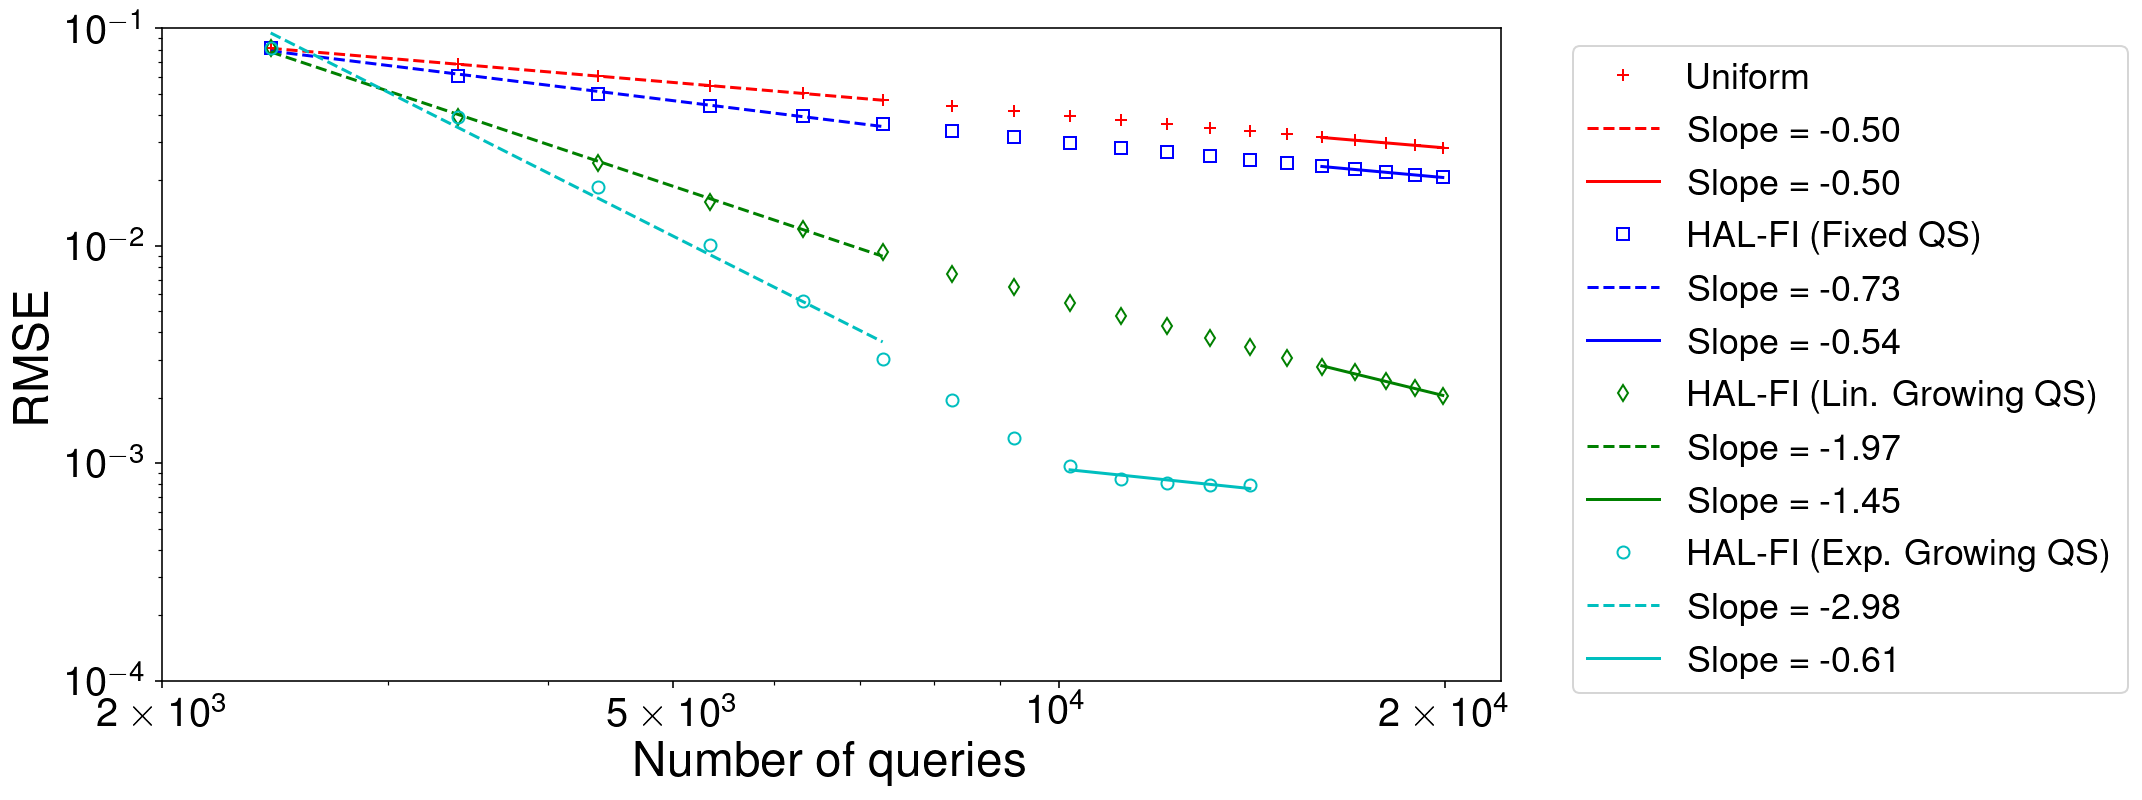

In [35]:
rmse_learners = []
rmse_learners.append(results_entropy_CR_uniform_d['rmse_param'])
rmse_learners.append(results_entropy_CR_fixed_d['rmse_param'])
rmse_learners.append(results_entropy_CR_lin_d['rmse_param'])
rmse_learners.append(results_entropy_CR_exp_d['rmse_param'][0:13])

_key = 'N_p'
nqueries_learners = []
nqueries_learners.append(results_entropy_CR_uniform_d[_key])
nqueries_learners.append(results_entropy_CR_fixed_d[_key])
nqueries_learners.append(results_entropy_CR_lin_d[_key])
nqueries_learners.append(results_entropy_CR_exp_d[_key][0:13])

labels_learners = ['Uniform', 'HAL-FI (Fixed QS)', 
                   'HAL-FI (Lin. Growing QS)',
                   'HAL-FI (Exp. Growing QS)']

design_experiment.plot_trends_comparison_learners(rmse_learners, nqueries_learners,
                                                  labels_learners=labels_learners, 
                                                  save_filename='rmse_omega_decoherence_uncertainty_filtering.pdf',
                                                  figsize_plot=(12,6))

### Saves

In [106]:
# Most of these computations are expensive (saving everything except for ActionSpace i.e., key = 'A_cr')
PL_d = {}
FI_fixed_d = {}
FI_lin_qs_d = {}
FI_exp_qs_d = {}

for _key in ['rmse_param', 'N_p', 'q_J', 'q_param', 'tvec']:
    PL_d.update({_key: results_entropy_CR_uniform_d[_key]})
    FI_fixed_d.update({_key: results_entropy_CR_fixed_d[_key]})
    FI_lin_qs_d.update({_key: results_entropy_CR_lin_d[_key]})
    FI_exp_qs_d.update({_key: results_entropy_CR_exp_d[_key]})

data_sim = {'PL': PL_d,
            'FI_fixed_qs': FI_fixed_d,
            'FI_lin_qs': FI_lin_qs_d,
            'FI_exp_qs': FI_exp_qs_d}

# Save to pickle file
pickle_filename = 'lower_bounds_rmse_reduced_HL_sim.pickle'
with open(pickle_filename, 'wb') as f:
    pickle.dump(data_sim, f)

### Load

In [23]:
pickle_filename = 'lower_bounds_rmse_reduced_HL_sim.pickle'

In [24]:
with open(pickle_filename, 'rb') as fp:
    results_entropy_CR = pickle.load(fp)

In [26]:
results_entropy_CR.keys()

dict_keys(['PL', 'FI_fixed_qs', 'FI_lin_qs', 'FI_exp_qs'])

In [27]:
results_entropy_CR_uniform_d = results_entropy_CR['PL']
results_entropy_CR_fixed_d = results_entropy_CR['FI_fixed_qs']
results_entropy_CR_lin_d = results_entropy_CR['FI_lin_qs']
results_entropy_CR_exp_d = results_entropy_CR['FI_exp_qs']

### Summary -- Time Information

In [43]:
reload_package(hamiltonianlearner)

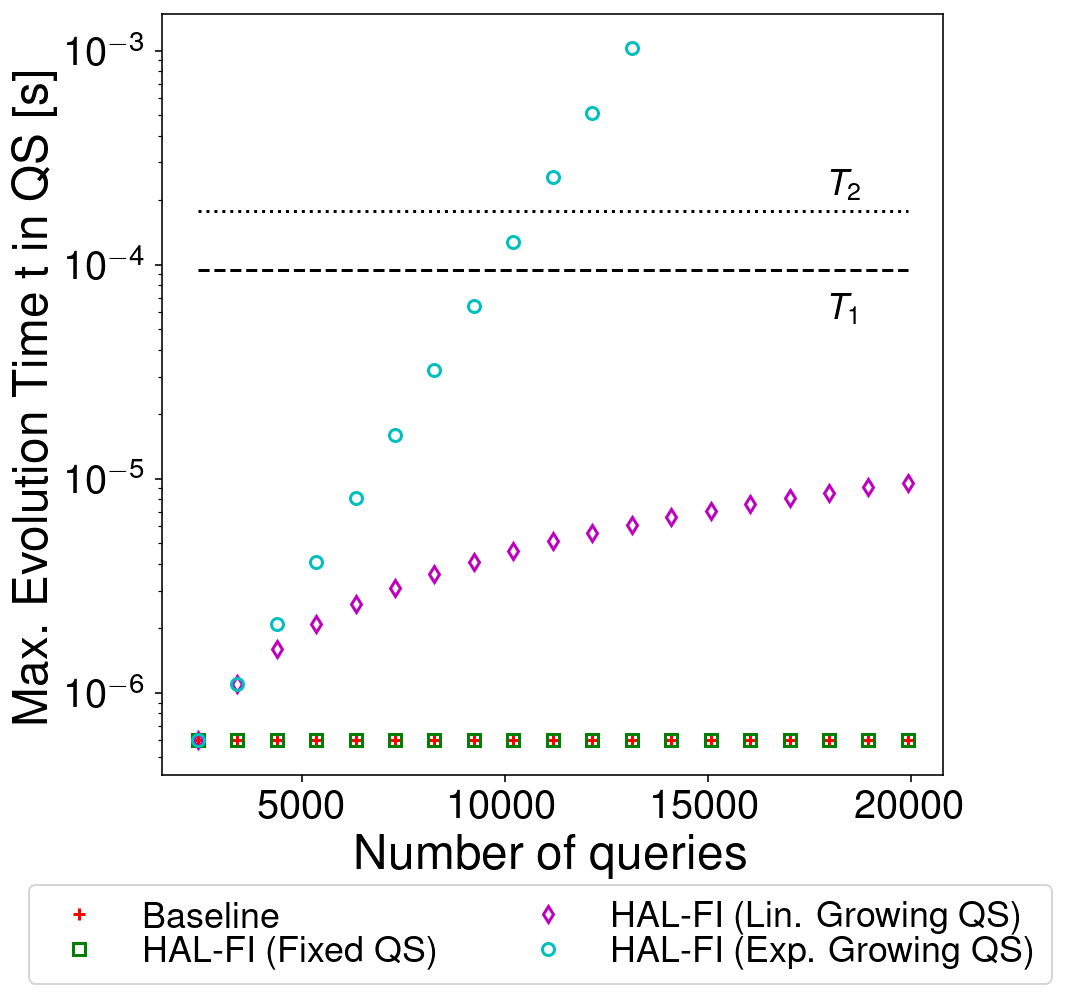

In [44]:
N_p_vec = results_entropy_CR_fixed_d['N_p']
N_p_min = N_p_vec[0]
N_p_max = N_p_vec[-1]

_key = 'tvec'
rmse_learners = []
rmse_learners.append(results_entropy_CR_uniform_d[_key])
rmse_learners.append(results_entropy_CR_fixed_d[_key])
rmse_learners.append(results_entropy_CR_lin_d[_key])
rmse_learners.append(results_entropy_CR_exp_d[_key][0:12])

_key = 'N_p'
nqueries_learners = []
nqueries_learners.append(results_entropy_CR_uniform_d[_key])
nqueries_learners.append(results_entropy_CR_fixed_d[_key])
nqueries_learners.append(results_entropy_CR_lin_d[_key])
nqueries_learners.append(results_entropy_CR_exp_d[_key][0:12])

labels_learners = ['Baseline', 'HAL-FI (Fixed QS)', 
                   'HAL-FI (Lin. Growing QS)',
                   'HAL-FI (Exp. Growing QS)']

design_experiment.plot_tvec_comparison_learners(rmse_learners, nqueries_learners, qs_T1, qs_T2, N_p_min, N_p_max,
                                                labels_learners=labels_learners, figsize_plot=(7,7),
                                                save_filename='comparison_tvec_trends_learners.pdf',
                                                FLAG_legend=True)